# Applying Principal Component Analysis for Protein Structure Analysis: Unveiling Patterns in Bioinformatics
#### LT1 Authors: **Fornan**, Glydel; **Jison**, Andgrel Heber; **Madarang**, Andrea; **Mendoza** Jr., Arthur; **Ona**, Juan Carlo

Dimensionality reduction techniques, such as Principal Component Analysis (PCA), are effective for simplifying high-dimensional data into lower-dimensional representations, making it easier to visualize, cluster, and analyze relationships between protein structures and their biological functions or disease associations. This project proposes using PCA to reduce protein structure data scraped from the AlphaFold Protein Structure Database. The transformed data will be explored through visualization and used to examine potential correlations with known protein functions and disease links.

In this project, we focused on the **G protein-coupled receptors** (GPCR) family of proteins as it is one of the largest and most diverse classes of proteins in the human genome. These receptors are involved in a wide variety of physiological processes, including neurotransmission, immune responses, and the regulation of blood pressure, among others. GPCRs work by binding ligands, which induce conformational changes in the receptors that activate intracellular signaling pathways through associated G proteins. As such, this family is of particular interest in drug discovery, being the targets of somewhere between 25 and 40% of all drugs currently in use (Zhang, Chen, et al., 2024; Odoemelam et al., 2020; Yang, Zhou, Labroska et al., 2020).

Despite its large number, GPCRs share a common architecture. They are made up of a single polypeptide that is embedded in the plasma membrane of a cell and folded into a globular shape. This molecule has seven segments that cover the whole membrane width, which is why GPCRs are frequently referred to as **seven-transmembrane receptors**. The remaining segments loop both within and outside the cell. The pockets where signaling molecules attach to the GPCR are partially made up of the extracellular loops. Due to this fact and for simplicity, our project used the coordinates of each atom of each of the transmembrane helix as the features.

In [1]:
import requests
import time
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.PDB import PDBParser
import py3Dmol
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

/Users/glydelfornan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Functions for extraction and preprocessing

In [2]:
# Combined function to get protein data and export files
def fetch_protein_data(uniprot_id, output_dirs):
    # Set up API endpoints
    api_url = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}"
    
    try:
        # Get protein details
        response = requests.get(api_url, timeout=10)
        response.raise_for_status()
        protein_data = response.json()[0]
        
        # Export PDB file
        pdb_url = protein_data.get('pdbUrl')
        if pdb_url:
            pdb_response = requests.get(pdb_url)
            with open(os.path.join(output_dirs['pdb'], f"{uniprot_id}.pdb"), 'wb') as pdb_file:
                pdb_file.write(pdb_response.content)
        
        # Export image file
        image_url = protein_data.get('paeImageUrl')
        if image_url:
            image_response = requests.get(image_url)
            with open(os.path.join(output_dirs['images'], f"{uniprot_id}_image.png"), 'wb') as image_file:
                image_file.write(image_response.content)

        # Save protein data as a text file
        with open(os.path.join(output_dirs['text'], f"{uniprot_id}_details.txt"), 'w') as text_file:
            json.dump(protein_data, text_file, indent=2)
        
        return protein_data
    except requests.RequestException as e:
        print(f"Error fetching data for {uniprot_id}: {e}")
        return None

In [3]:
# Extract helical details for each protein
def extract_helical_regions(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json?fields=ft_topo_dom%2Cft_transmem"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching data for {uniprot_id}")
        return None

    data = response.json()
    tm_regions = []
    for feature in data.get('features', []):
        if feature.get('type') == 'Transmembrane' and 'Helical' in feature.get('description', ''):
            start = feature['location']['start']['value']
            end = feature['location']['end']['value']
            tm_regions.append((start, end))
    return tm_regions

In [4]:
# Generate a dataframe with start and end positions of TMHs
def create_helical_df(uniprot_ids):
    data = []
    for uniprot_id in uniprot_ids:
        tm_regions = extract_helical_regions(uniprot_id)
        if tm_regions is not None:
            row = [uniprot_id] + [coord for region in tm_regions for coord in region]
            data.append(row + [None] * (15 - len(row)))  # Pad to maintain consistent column count
        print(f"Successfully extracted helical details for {uniprot_id}")
    column_names = ['protein'] + [f'TMH {i+1} Start' for i in range(7)] + [f'TMH {i+1} End' for i in range(7)]
    return pd.DataFrame(data, columns=column_names)

In [5]:
# Parse C-alpha coordinates and create final dataframe
def parse_coordinates(pdb_file, tmh_positions):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords = {f'TMH {i+1}': [] for i in range(7)}

    for tmh_idx, (start, end) in enumerate(tmh_positions):
        atoms = []
        for model in structure:
            for chain in model:
                for residue in chain.get_residues():
                    if start <= residue.id[1] <= end and "CA" in residue:
                        atom = residue["CA"]
                        atoms.extend(atom.coord)
        coords[f'TMH {tmh_idx+1}'] = atoms

    # Flatten coordinates into dataframe format
    data = {'protein': pdb_file}
    for tmh, atom_coords in coords.items():
        for idx, coord in enumerate(atom_coords):
            data[f'{tmh} Atom {idx // 3 + 1} {["X", "Y", "Z"][idx % 3]}'] = coord
    return pd.DataFrame([data])

In [6]:
# 3D visualization
def visualize_proteins(uniprot_ids, output_dirs):
    os.makedirs(output_dirs['pdb'], exist_ok=True)

    for uniprot_id in uniprot_ids:
        pdb_file_path = os.path.join('PDB_Files', f"{uniprot_id}.pdb")
        
        if os.path.exists(pdb_file_path):
            with open(pdb_file_path, 'r') as pdb_file:
                pdb_data = pdb_file.read()
            
            view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
            view.addModel(pdb_data, 'pdb')
            view.setStyle({'cartoon': {'color': 'spectrum'}})
            view.zoomTo()
            display(view)
        else:
            print(f"PDB file for {uniprot_id} not found in PDB_Files folder.")


In [7]:
# Final dataframe
def process_proteins(uniprot_ids, output_dirs):
    os.makedirs(output_dirs['pdb'], exist_ok=True)
    os.makedirs(output_dirs['images'], exist_ok=True)
    os.makedirs(output_dirs['text'], exist_ok=True)
    
    final_coord_dfs = []
    for uniprot_id in uniprot_ids:
        protein_data = fetch_protein_data(uniprot_id, output_dirs)
        
        if protein_data:
            # Extract and parse TMH coordinates
            tmh_positions = extract_helical_regions(uniprot_id)
            if tmh_positions:
                pdb_file = os.path.join(output_dirs['pdb'], f"{uniprot_id}.pdb")
                coord_df = parse_coordinates(pdb_file, tmh_positions)
                final_coord_dfs.append(coord_df)
        print(f"Successfully processed {uniprot_id}!")
    
    final_coord_df = pd.concat(final_coord_dfs, ignore_index=True)
    final_coord_df['protein'] = final_coord_df['protein'].str.extract(r'([^/]+)\.pdb$')[0]
    
    return final_coord_df

## Data Extraction

To choose the proteins that we will be including in our investigation, we consulted the [IUPHAR/BPS Guide to PHARMACOLOGY](https://www.guidetopharmacology.org/GRAC/ReceptorFamiliesForward?type=GPCR) and made use of its list of GPCRs (see the file `GPCRTargets-updated.csv`). From this list, we extracted the *SwissProt Name*, *Family ID*, *Family Name*, and *Class* of each protein. For convention, we will refer to each protein by its *SwissProt* (or uniprot) *Name*.

In [8]:
file_path = 'GPCRTargets-updated.csv'
gpcr_targets_df = pd.read_csv(file_path, header=1)
gpcr_targets_df.head()

,Type,Family id,Family name,Class,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,...,Rat SwissProt,Rat Entrez Gene,MGI id,MGI symbol,MGI name,Mouse genetic localisation,Mouse nucleotide RefSeq,Mouse protein RefSeq,Mouse SwissProt,Mouse Entrez Gene
0,gpcr,16,Class A Orphans,Orphan A,83,<i>GPR3</i>,NaN,NaN,NaN,Gpcr21|GPCR3|ACCA orphan receptor|adenylate cy...,...,Q8K1Q3,266769,MGI:101908,Gpr3,G-protein coupled receptor 3,4 D2.3,NM_008154,NP_032180,P35413,14748
1,gpcr,16,Class A Orphans,Orphan A,84,<i>GPR4</i>,NaN,NaN,NaN,GPR19|G-protein coupled receptor 19,...,Q4KLH9,308408,MGI:2441992,Gpr4,G protein-coupled receptor 4,7 A3,NM_175668,NP_783599,Q8BUD0,319197
2,gpcr,16,Class A Orphans,Orphan A,228,<i>GPR42</i>,NaN,NaN,NaN,FFAR1L|GPR41L|FFAR3L|G protein-coupled recepto...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gpcr,16,Class A Orphans,Orphan A,85,<i>GPR6</i>,NaN,NaN,NaN,Sphingosine 1-phosphate receptor GPR6,...,P51651,83683,MGI:2155249,Gpr6,G protein-coupled receptor 6,10 22.08 cM,NM_199058,NP_951013,Q6YNI2,140741
4,gpcr,16,Class A Orphans,Orphan A,86,<i>GPR12</i>,NaN,NaN,NaN,Gpcr01|Gpcr20|GPCR21|GPCR12|R334,...,P30951,80840,MGI:101909,Gpr12,G-protein coupled receptor 12,5 G3,NM_008151,NP_032177,P35412,14738


In [9]:
gpcr_targets_df = gpcr_targets_df[['Human SwissProt', 'Family id', 'Class']].dropna(subset=['Human SwissProt'])
uniprot_ids = gpcr_targets_df['Human SwissProt'].tolist()
uniprot_ids

['P46089',
 'P46093',
 'O15529',
 'P46095',
 'P47775',
 'P49685',
 'Q13304',
 'Q15760',
 'Q99678',
 'Q99679',
 'Q99680',
 'O00155',
 'Q8NDV2',
 'Q9NS67',
 'O00270',
 'O75388',
 'Q49SQ1',
 'Q9UPC5',
 'Q9HC97',
 'O15354',
 'O60883',
 'O43194',
 'Q9Y5Y3',
 'Q13585',
 'Q9Y2T5',
 'Q9BZJ8',
 'Q9BZJ7',
 'Q9BZJ6',
 'Q8IYL9',
 'Q15743',
 'O95800',
 'Q96P69',
 'Q96P67',
 'Q9NYM4',
 'Q9NQS5',
 'P60893',
 'Q9BY21',
 'Q9GZN0',
 'Q96P66',
 'Q9UNW8',
 'Q8IZ08',
 'Q6DWJ6',
 'Q7Z602',
 'Q7Z601',
 'Q96CH1',
 'Q8TDV2',
 'Q86SP6',
 'Q8NGU9',
 'Q8TDV0',
 'Q8TDT2',
 'Q6NV75',
 'Q9UJ42',
 'Q8N6U8',
 'Q16538',
 'O14626',
 'Q9NS66',
 'Q9BXC1',
 'Q14439',
 'O15218',
 'P32249',
 'Q9BXB1',
 'O75473',
 'Q9HBX8',
 'P04201',
 'P35410',
 'Q8TDS7',
 'Q86SM8',
 'Q96AM1',
 'Q86SM5',
 'Q96LB2',
 'Q96LB1',
 'Q96LB0',
 'Q96LA9',
 'Q86VZ1',
 'O00398',
 'Q9P1P5',
 'Q9P1P4',
 'O14804',
 'Q96RI8',
 'Q969N4',
 'Q96RI9',
 'Q8NFN8',
 'Q5T848',
 'Q6PRD1',
 'Q8NFJ5',
 'Q9NZH0',
 'Q9NQ84',
 'Q9NZD1',
 'Q5T6X5',
 'P04000',
 'P04001',

Since we are only using the 7 transmembrane helices of each protein, we had to identify the start and end position IDs of each atom of each of the 7 transmembrane helices of each protein. We extracted this using the `https://rest.uniprot.org/uniprotkb/{uniprot_id}.json?fields=ft_topo_dom%2Cft_transmem` API by simply inputting the *SwissProt* identifier of each protein.

In [10]:
# Generate TMH dataframe
tmh_df = create_helical_df(uniprot_ids)

Successfully extracted helical details for P46089
Successfully extracted helical details for P46093
Successfully extracted helical details for O15529
Successfully extracted helical details for P46095
Successfully extracted helical details for P47775
Successfully extracted helical details for P49685
Successfully extracted helical details for Q13304
Successfully extracted helical details for Q15760
Successfully extracted helical details for Q99678
Successfully extracted helical details for Q99679
Successfully extracted helical details for Q99680
Successfully extracted helical details for O00155
Successfully extracted helical details for Q8NDV2
Successfully extracted helical details for Q9NS67
Successfully extracted helical details for O00270
Successfully extracted helical details for O75388
Successfully extracted helical details for Q49SQ1
Successfully extracted helical details for Q9UPC5
Successfully extracted helical details for Q9HC97
Successfully extracted helical details for O15354


In [11]:
tmh_df

,protein,TMH 1 Start,TMH 2 Start,TMH 3 Start,TMH 4 Start,TMH 5 Start,TMH 6 Start,TMH 7 Start,TMH 1 End,TMH 2 End,TMH 3 End,TMH 4 End,TMH 5 End,TMH 6 End,TMH 7 End
0,P46089,43,62,75,98,111,132,154,173,199,217,246.0,272.0,278.0,299.0
1,P46093,18,42,55,76,92,113,133,154,180,201,225.0,245.0,264.0,284.0
2,O15529,20,40,48,68,91,111,133,153,179,199,223.0,243.0,259.0,279.0
3,P46095,75,94,107,130,143,164,186,205,231,249,278.0,304.0,310.0,331.0
4,P47775,49,69,78,98,114,134,159,179,200,220,253.0,273.0,283.0,303.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,P30518,39,63,78,98,114,135,160,180,201,220,272.0,293.0,309.0,328.0
396,P30559,39,63,75,97,114,135,155,175,203,225,276.0,294.0,310.0,332.0
397,P41586,156,178,187,205,228,253,269,291,310,332,351.0,371.0,386.0,405.0
398,P32241,143,167,175,194,217,240,255,276,293,316,342.0,361.0,374.0,393.0


Here, we extracted the PDB file, image, and description of each protein from the [AlphaFold](https://alphafold.ebi.ac.uk/) database through the `https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}` API. Each PDB (Protein Data Bank) file contains the 3D structural data of each protein. We used these files to further extract the $X$, $Y$, and $Z$ coordinates of each considered atom.

In [12]:
# Generate final parsed coordinates dataframe
output_dirs = {
    'pdb': 'PDB_Files',
    'images': 'Images',
    'text': 'Text_Files'
}

coordinates_df = process_proteins(uniprot_ids, output_dirs)

Successfully processed P46089!
Successfully processed P46093!
Successfully processed O15529!
Successfully processed P46095!
Successfully processed P47775!
Successfully processed P49685!
Successfully processed Q13304!
Successfully processed Q15760!
Successfully processed Q99678!
Successfully processed Q99679!
Successfully processed Q99680!
Successfully processed O00155!
Successfully processed Q8NDV2!
Successfully processed Q9NS67!
Successfully processed O00270!
Successfully processed O75388!
Successfully processed Q49SQ1!
Successfully processed Q9UPC5!
Successfully processed Q9HC97!
Successfully processed O15354!
Successfully processed O60883!
Successfully processed O43194!
Successfully processed Q9Y5Y3!
Successfully processed Q13585!
Successfully processed Q9Y2T5!
Successfully processed Q9BZJ8!
Successfully processed Q9BZJ7!
Successfully processed Q9BZJ6!
Successfully processed Q8IYL9!
Successfully processed Q15743!
Successfully processed O95800!
Successfully processed Q96P69!
Successf

In [13]:
coordinates_df

,protein,TMH 1 Atom 1 X,TMH 1 Atom 1 Y,TMH 1 Atom 1 Z,TMH 1 Atom 2 X,TMH 1 Atom 2 Y,TMH 1 Atom 2 Z,TMH 1 Atom 3 X,TMH 1 Atom 3 Y,TMH 1 Atom 3 Z,...,TMH 6 Atom 37 Z,TMH 6 Atom 38 X,TMH 6 Atom 38 Y,TMH 6 Atom 38 Z,TMH 6 Atom 39 X,TMH 6 Atom 39 Y,TMH 6 Atom 39 Z,TMH 6 Atom 40 X,TMH 6 Atom 40 Y,TMH 6 Atom 40 Z
0,P46089,18.181000,9.848,2.520,18.709,6.383,0.899000,20.353001,5.215,4.158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P46093,16.534000,8.483,-2.642,12.923,9.488,-1.816000,10.896000,6.470,-3.201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O15529,-4.308000,8.137,-11.168,-2.104,10.098,-8.703000,-4.585000,13.022,-8.735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P46095,16.537001,10.738,-0.570,17.379,7.001,-0.938000,19.110001,7.116,2.495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P47775,18.605000,-7.709,-5.014,17.539,-6.518,-1.502000,14.363000,-4.891,-2.952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,P30518,-1.123000,-11.384,-22.521,-0.009,-8.411,-20.327999,-1.925000,-5.950,-22.576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,P30559,18.979000,17.716,-1.864,20.632,18.118,1.610000,17.183001,18.646,3.202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,P41586,-14.070000,-0.128,-14.074,-11.946,1.544,-11.334000,-12.740000,5.087,-12.670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
393,P32241,-6.532000,-4.218,-12.903,-9.990,-5.224,-14.145000,-10.675000,-7.064,-10.840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Visualize each protein
# visualize_proteins(uniprot_ids, output_dirs)

## Data Preprocessing

For our preprocessing, we employed the following steps:

1. Remove columns with more than 50% of NaN values since a lot of missing data will just skew the imputation and analysis.
2. Impute the missing values in each column with the mean.
3. Standardize the coordinates for consistency.

In [15]:
# Drop columns with more than 50% NA values
threshold = len(coordinates_df) * 0.5
df_cleaned = coordinates_df.dropna(axis=1, thresh=threshold)

# Handle missing numeric values by filling NaNs with the mean of each column
df_cleaned.iloc[:, 1:] = df_cleaned.iloc[:, 1:].fillna(df_cleaned.iloc[:, 1:].mean())

# Sort columns based on the desired criteria (TMH, atom, axis)
def extract_sort_key(col):
    parts = col.split(' ')
    tmh = int(parts[1])  # Extract TMH number (1 to 7)
    atom = int(parts[3])  # Extract atom number
    axis = parts[4]  # X, Y, or Z
    return (tmh, atom, axis)

# Get columns and sort them
columns = df_cleaned.columns[1:]  # Exclude protein column
sorted_columns = sorted(columns, key=extract_sort_key)

# Reorder columns
df_cleaned = df_cleaned[['protein'] + sorted_columns]

# Standardize the numeric columns
df_cleaned.iloc[:, 1:] = StandardScaler().fit_transform(df_cleaned.iloc[:, 1:])
df_cleaned

,protein,TMH 1 Atom 1 X,TMH 1 Atom 1 Y,TMH 1 Atom 1 Z,TMH 1 Atom 2 X,TMH 1 Atom 2 Y,TMH 1 Atom 2 Z,TMH 1 Atom 3 X,TMH 1 Atom 3 Y,TMH 1 Atom 3 Z,...,TMH 7 Atom 18 Z,TMH 7 Atom 19 X,TMH 7 Atom 19 Y,TMH 7 Atom 19 Z,TMH 7 Atom 20 X,TMH 7 Atom 20 Y,TMH 7 Atom 20 Z,TMH 7 Atom 21 X,TMH 7 Atom 21 Y,TMH 7 Atom 21 Z
0,P46089,1.081149,0.608960,0.451045,1.158123,0.372812,0.333504,1.287727,0.298273,0.505472,...,0.776262,0.319234,0.283434,0.649795,0.270243,-0.100927,0.590949,3.845690e-01,-3.580479e-01,6.774335e-01
1,P46093,0.980743,0.505243,0.146315,0.803285,0.618525,0.168424,0.702032,0.400986,0.049565,...,0.171103,0.224486,0.123044,0.167695,0.316374,0.070567,0.353600,2.517439e-01,4.788393e-01,3.685369e-01
2,O15529,-0.289853,0.478953,-0.357002,-0.118275,0.666798,-0.250327,-0.256745,0.937223,-0.293279,...,0.233057,-0.334262,0.201736,0.163338,-0.297644,-0.209453,0.173446,-1.618804e-01,-1.782399e-01,3.136829e-01
3,P46095,0.980926,0.676585,0.268632,1.076558,0.421717,0.221809,1.210745,0.453857,0.402445,...,0.688419,0.273178,0.491490,0.542604,0.250077,0.087867,0.515991,3.736079e-01,-9.929439e-02,6.257856e-01
4,P47775,1.106997,-0.725074,0.006288,1.086370,-0.648105,0.187516,0.916752,-0.528836,0.064991,...,0.498537,0.304061,-0.719916,0.386087,0.378492,-1.124729,0.389527,4.592281e-01,-1.066812e+00,5.662097e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,P30518,-0.095685,-1.004312,-1.027207,0.010205,-0.797907,-0.957163,-0.092005,-0.615508,-1.150761,...,-0.507766,-0.720785,-0.978108,-0.363789,-0.654154,-0.778627,-0.191919,6.013296e-09,-1.061695e-08,3.140129e-08
391,P30559,1.129798,1.206794,0.192243,1.276054,1.301458,0.376735,1.091401,1.397510,0.446245,...,0.735082,0.445887,0.702230,0.637885,0.492905,0.340916,0.715918,5.777832e-01,5.731595e-01,8.615238e-01
392,P41586,-0.884976,-0.149047,-0.528553,-0.721855,-0.010121,-0.410300,-0.761804,0.287797,-0.537061,...,0.103180,-0.962255,0.427076,0.275526,-1.057997,0.432143,0.383261,6.013296e-09,-1.061695e-08,3.140129e-08
393,P32241,-0.425435,-0.459817,-0.459425,-0.601900,-0.545704,-0.581218,-0.633914,-0.706681,-0.423689,...,0.120298,-1.060769,-0.126452,0.258212,-1.171522,-0.180549,0.330261,6.013296e-09,-1.061695e-08,3.140129e-08


In [16]:
final_df = pd.merge(df_cleaned, gpcr_targets_df, left_on='protein', right_on='Human SwissProt', how='inner')
final_df = final_df.drop(columns=['Human SwissProt'])
final_df

,protein,TMH 1 Atom 1 X,TMH 1 Atom 1 Y,TMH 1 Atom 1 Z,TMH 1 Atom 2 X,TMH 1 Atom 2 Y,TMH 1 Atom 2 Z,TMH 1 Atom 3 X,TMH 1 Atom 3 Y,TMH 1 Atom 3 Z,...,TMH 7 Atom 19 Y,TMH 7 Atom 19 Z,TMH 7 Atom 20 X,TMH 7 Atom 20 Y,TMH 7 Atom 20 Z,TMH 7 Atom 21 X,TMH 7 Atom 21 Y,TMH 7 Atom 21 Z,Family id,Class
0,P46089,1.081149,0.608960,0.451045,1.158123,0.372812,0.333504,1.287727,0.298273,0.505472,...,0.283434,0.649795,0.270243,-0.100927,0.590949,3.845690e-01,-3.580479e-01,6.774335e-01,16,Orphan A
1,P46093,0.980743,0.505243,0.146315,0.803285,0.618525,0.168424,0.702032,0.400986,0.049565,...,0.123044,0.167695,0.316374,0.070567,0.353600,2.517439e-01,4.788393e-01,3.685369e-01,16,Orphan A
2,O15529,-0.289853,0.478953,-0.357002,-0.118275,0.666798,-0.250327,-0.256745,0.937223,-0.293279,...,0.201736,0.163338,-0.297644,-0.209453,0.173446,-1.618804e-01,-1.782399e-01,3.136829e-01,16,Orphan A
3,O15529,-0.289853,0.478953,-0.357002,-0.118275,0.666798,-0.250327,-0.256745,0.937223,-0.293279,...,0.201736,0.163338,-0.297644,-0.209453,0.173446,-1.618804e-01,-1.782399e-01,3.136829e-01,24,A
4,P46095,0.980926,0.676585,0.268632,1.076558,0.421717,0.221809,1.210745,0.453857,0.402445,...,0.491490,0.542604,0.250077,0.087867,0.515991,3.736079e-01,-9.929439e-02,6.257856e-01,16,Orphan A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,P30518,-0.095685,-1.004312,-1.027207,0.010205,-0.797907,-0.957163,-0.092005,-0.615508,-1.150761,...,-0.978108,-0.363789,-0.654154,-0.778627,-0.191919,6.013296e-09,-1.061695e-08,3.140129e-08,66,A
395,P30559,1.129798,1.206794,0.192243,1.276054,1.301458,0.376735,1.091401,1.397510,0.446245,...,0.702230,0.637885,0.492905,0.340916,0.715918,5.777832e-01,5.731595e-01,8.615238e-01,66,A
396,P41586,-0.884976,-0.149047,-0.528553,-0.721855,-0.010121,-0.410300,-0.761804,0.287797,-0.537061,...,0.427076,0.275526,-1.057997,0.432143,0.383261,6.013296e-09,-1.061695e-08,3.140129e-08,67,B
397,P32241,-0.425435,-0.459817,-0.459425,-0.601900,-0.545704,-0.581218,-0.633914,-0.706681,-0.423689,...,-0.126452,0.258212,-1.171522,-0.180549,0.330261,6.013296e-09,-1.061695e-08,3.140129e-08,67,B


Since some proteins can have two or more classes, we further distinguished them with a new identifier.

In [17]:
final_df['protein identifier'] = final_df.groupby('protein').cumcount().add(1).apply(lambda x: f'-{x}' if x > 1 else '')
final_df['protein'] =final_df['protein'] + final_df['protein identifier']
final_df

,protein,TMH 1 Atom 1 X,TMH 1 Atom 1 Y,TMH 1 Atom 1 Z,TMH 1 Atom 2 X,TMH 1 Atom 2 Y,TMH 1 Atom 2 Z,TMH 1 Atom 3 X,TMH 1 Atom 3 Y,TMH 1 Atom 3 Z,...,TMH 7 Atom 19 Z,TMH 7 Atom 20 X,TMH 7 Atom 20 Y,TMH 7 Atom 20 Z,TMH 7 Atom 21 X,TMH 7 Atom 21 Y,TMH 7 Atom 21 Z,Family id,Class,protein identifier
0,P46089,1.081149,0.608960,0.451045,1.158123,0.372812,0.333504,1.287727,0.298273,0.505472,...,0.649795,0.270243,-0.100927,0.590949,3.845690e-01,-3.580479e-01,6.774335e-01,16,Orphan A,
1,P46093,0.980743,0.505243,0.146315,0.803285,0.618525,0.168424,0.702032,0.400986,0.049565,...,0.167695,0.316374,0.070567,0.353600,2.517439e-01,4.788393e-01,3.685369e-01,16,Orphan A,
2,O15529,-0.289853,0.478953,-0.357002,-0.118275,0.666798,-0.250327,-0.256745,0.937223,-0.293279,...,0.163338,-0.297644,-0.209453,0.173446,-1.618804e-01,-1.782399e-01,3.136829e-01,16,Orphan A,
3,O15529-2,-0.289853,0.478953,-0.357002,-0.118275,0.666798,-0.250327,-0.256745,0.937223,-0.293279,...,0.163338,-0.297644,-0.209453,0.173446,-1.618804e-01,-1.782399e-01,3.136829e-01,24,A,-2
4,P46095,0.980926,0.676585,0.268632,1.076558,0.421717,0.221809,1.210745,0.453857,0.402445,...,0.542604,0.250077,0.087867,0.515991,3.736079e-01,-9.929439e-02,6.257856e-01,16,Orphan A,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,P30518,-0.095685,-1.004312,-1.027207,0.010205,-0.797907,-0.957163,-0.092005,-0.615508,-1.150761,...,-0.363789,-0.654154,-0.778627,-0.191919,6.013296e-09,-1.061695e-08,3.140129e-08,66,A,
395,P30559,1.129798,1.206794,0.192243,1.276054,1.301458,0.376735,1.091401,1.397510,0.446245,...,0.637885,0.492905,0.340916,0.715918,5.777832e-01,5.731595e-01,8.615238e-01,66,A,
396,P41586,-0.884976,-0.149047,-0.528553,-0.721855,-0.010121,-0.410300,-0.761804,0.287797,-0.537061,...,0.275526,-1.057997,0.432143,0.383261,6.013296e-09,-1.061695e-08,3.140129e-08,67,B,
397,P32241,-0.425435,-0.459817,-0.459425,-0.601900,-0.545704,-0.581218,-0.633914,-0.706681,-0.423689,...,0.258212,-1.171522,-0.180549,0.330261,6.013296e-09,-1.061695e-08,3.140129e-08,67,B,


In [18]:
final_features_df = final_df.iloc[:, 1:442]
final_features_df

,TMH 1 Atom 1 X,TMH 1 Atom 1 Y,TMH 1 Atom 1 Z,TMH 1 Atom 2 X,TMH 1 Atom 2 Y,TMH 1 Atom 2 Z,TMH 1 Atom 3 X,TMH 1 Atom 3 Y,TMH 1 Atom 3 Z,TMH 1 Atom 4 X,...,TMH 7 Atom 18 Z,TMH 7 Atom 19 X,TMH 7 Atom 19 Y,TMH 7 Atom 19 Z,TMH 7 Atom 20 X,TMH 7 Atom 20 Y,TMH 7 Atom 20 Z,TMH 7 Atom 21 X,TMH 7 Atom 21 Y,TMH 7 Atom 21 Z
0,1.081149,0.608960,0.451045,1.158123,0.372812,0.333504,1.287727,0.298273,0.505472,1.122320,...,0.776262,0.319234,0.283434,0.649795,0.270243,-0.100927,0.590949,3.845690e-01,-3.580479e-01,6.774335e-01
1,0.980743,0.505243,0.146315,0.803285,0.618525,0.168424,0.702032,0.400986,0.049565,0.857724,...,0.171103,0.224486,0.123044,0.167695,0.316374,0.070567,0.353600,2.517439e-01,4.788393e-01,3.685369e-01
2,-0.289853,0.478953,-0.357002,-0.118275,0.666798,-0.250327,-0.256745,0.937223,-0.293279,-0.424030,...,0.233057,-0.334262,0.201736,0.163338,-0.297644,-0.209453,0.173446,-1.618804e-01,-1.782399e-01,3.136829e-01
3,-0.289853,0.478953,-0.357002,-0.118275,0.666798,-0.250327,-0.256745,0.937223,-0.293279,-0.424030,...,0.233057,-0.334262,0.201736,0.163338,-0.297644,-0.209453,0.173446,-1.618804e-01,-1.782399e-01,3.136829e-01
4,0.980926,0.676585,0.268632,1.076558,0.421717,0.221809,1.210745,0.453857,0.402445,1.026581,...,0.688419,0.273178,0.491490,0.542604,0.250077,0.087867,0.515991,3.736079e-01,-9.929439e-02,6.257856e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,-0.095685,-1.004312,-1.027207,0.010205,-0.797907,-0.957163,-0.092005,-0.615508,-1.150761,-0.273592,...,-0.507766,-0.720785,-0.978108,-0.363789,-0.654154,-0.778627,-0.191919,6.013296e-09,-1.061695e-08,3.140129e-08
395,1.129798,1.206794,0.192243,1.276054,1.301458,0.376735,1.091401,1.397510,0.446245,1.021389,...,0.735082,0.445887,0.702230,0.637885,0.492905,0.340916,0.715918,5.777832e-01,5.731595e-01,8.615238e-01
396,-0.884976,-0.149047,-0.528553,-0.721855,-0.010121,-0.410300,-0.761804,0.287797,-0.537061,-0.979737,...,0.103180,-0.962255,0.427076,0.275526,-1.057997,0.432143,0.383261,6.013296e-09,-1.061695e-08,3.140129e-08
397,-0.425435,-0.459817,-0.459425,-0.601900,-0.545704,-0.581218,-0.633914,-0.706681,-0.423689,-0.567608,...,0.120298,-1.060769,-0.126452,0.258212,-1.171522,-0.180549,0.330261,6.013296e-09,-1.061695e-08,3.140129e-08


In [19]:
final_targets_df = final_df[['protein', 'Family id', 'Class']]
final_targets_df

,protein,Family id,Class
0,P46089,16,Orphan A
1,P46093,16,Orphan A
2,O15529,16,Orphan A
3,O15529-2,24,A
4,P46095,16,Orphan A
...,...,...,...
394,P30518,66,A
395,P30559,66,A
396,P41586,67,B
397,P32241,67,B


# Principal Component Analysis

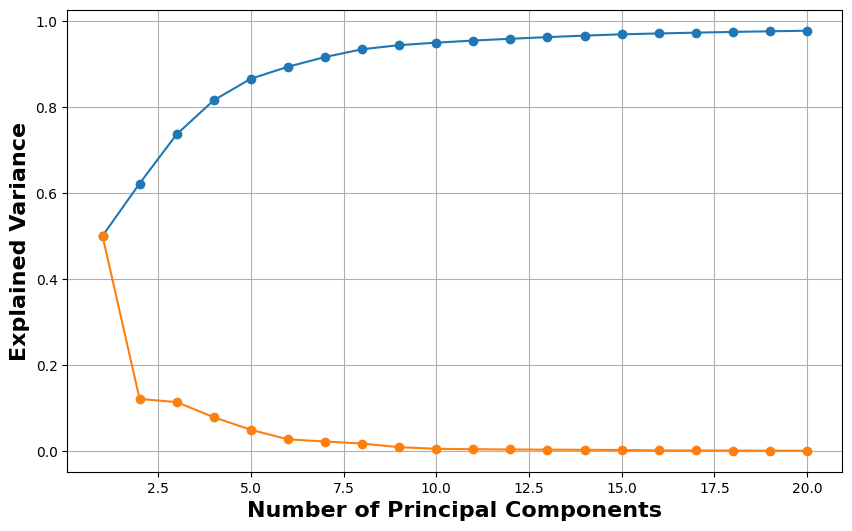

The best number of components that explain at least 90% of the variance: 7
Combined variance of the 7 components: 91.63%
Explained variance ratio of the 7 components: [0.5005121  0.12174795 0.11431041 0.07918577 0.04998644 0.02777058
 0.02274397 0.01800298 0.0095823  0.00576732 0.00484075 0.00418285
 0.00382148 0.00349175 0.00303749 0.00200042 0.00186151 0.00171438
 0.00143924 0.00134243]


In [20]:
explained_variance_ratios = []
cumulative_variance = []

for n in range(1, 21):
    pca = PCA(n_components=n)
    pca.fit(final_features_df)
    explained_variance_ratios.append(pca.explained_variance_ratio_)
    cumulative_variance.append(np.cumsum(pca.explained_variance_ratio_))

explained_variance_df = pd.DataFrame(explained_variance_ratios, columns=[f'PC{i+1}' for i in range(20)])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=[f'PC{i+1}' for i in range(20)])

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 21), cumulative_variance_df.iloc[-1, :], marker='o', label='cumulative')
plt.plot(np.arange(1, 21), explained_variance_df.iloc[-1, :], marker='o', label='individual')
plt.xlabel('Number of Principal Components', fontsize=16, fontweight='bold')
plt.ylabel('Explained Variance', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()

for i, cum_variance in enumerate(cumulative_variance_df.iloc[-1, :]):
    if cum_variance >= 0.9:
        best_n_components = i + 1
        break

print(f"The best number of components that explain at least 90% of the variance: {best_n_components}")
print(f"Combined variance of the {best_n_components} components: {explained_variance_df.iloc[-1, :][:best_n_components].sum() * 100:.2f}%")
print(f"Explained variance ratio of the {best_n_components} components: {pca.explained_variance_ratio_}")

In [21]:
# We now perform PCA with the selected best n_components
pca = PCA(n_components=best_n_components)
pca_result = pca.fit_transform(final_features_df)

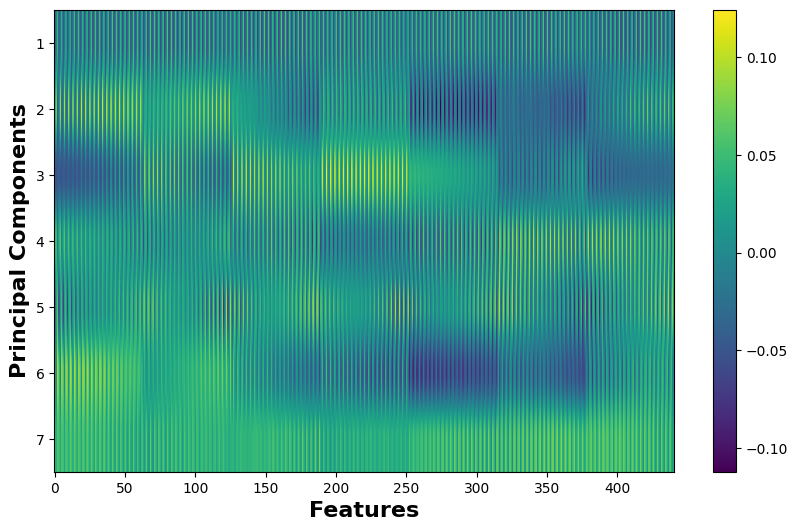

In [22]:
plt.figure(figsize=(10, 6))
plt.imshow(pca.components_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.ylabel('Principal Components', fontsize=16, fontweight='bold')
plt.yticks(ticks=range(7), labels=[str(i) for i in range(1, 8)])
plt.xlabel('Features', fontsize=16, fontweight='bold')
plt.show()

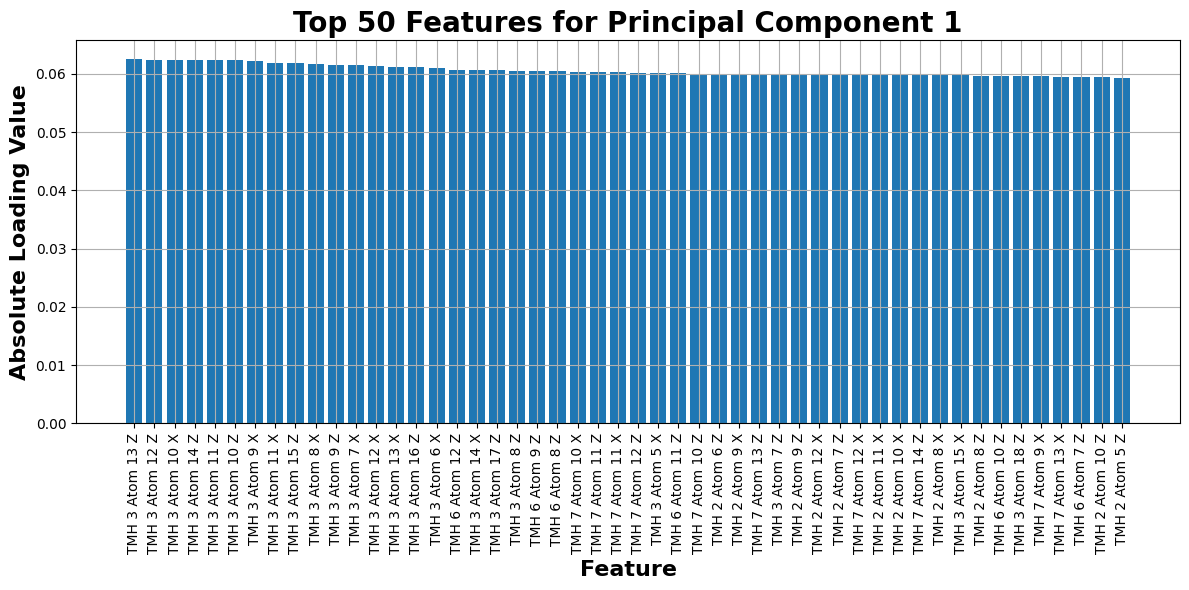

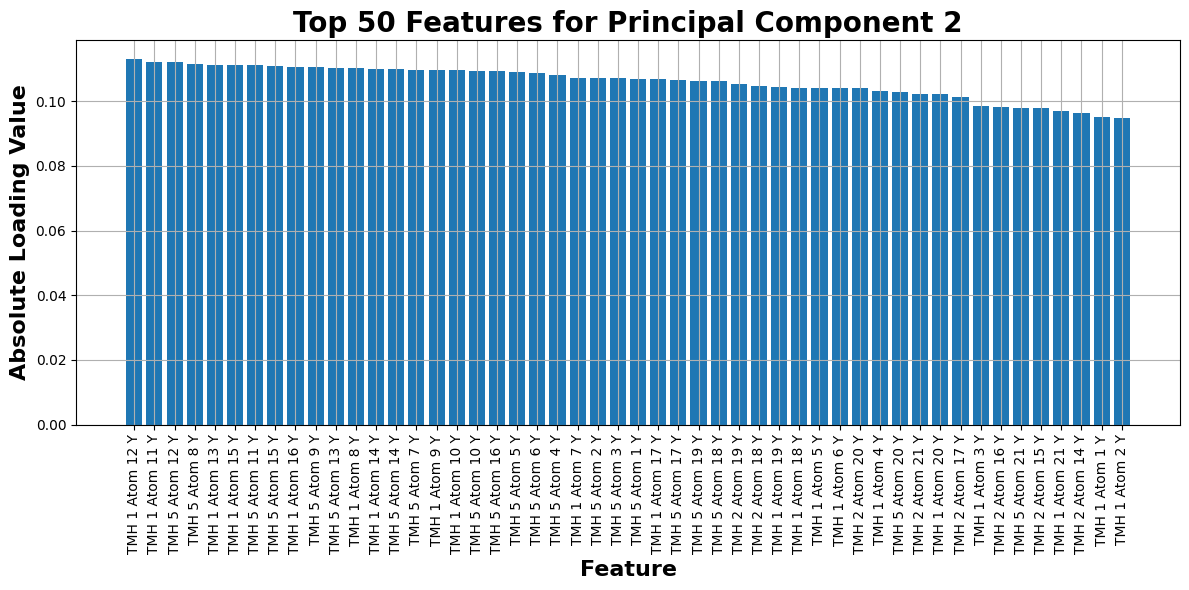

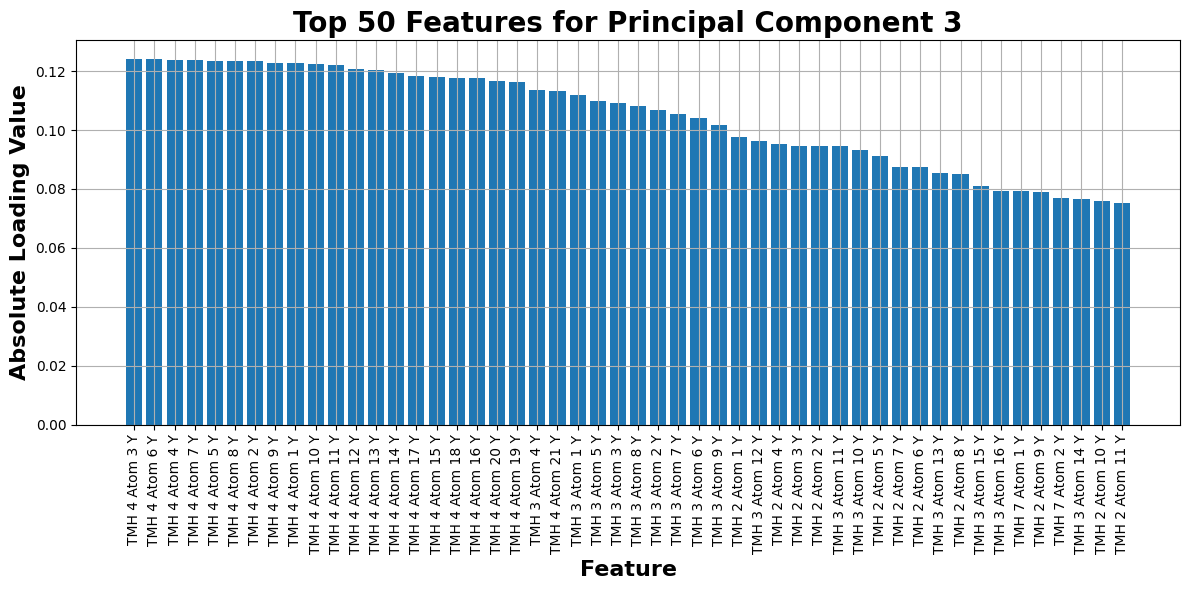

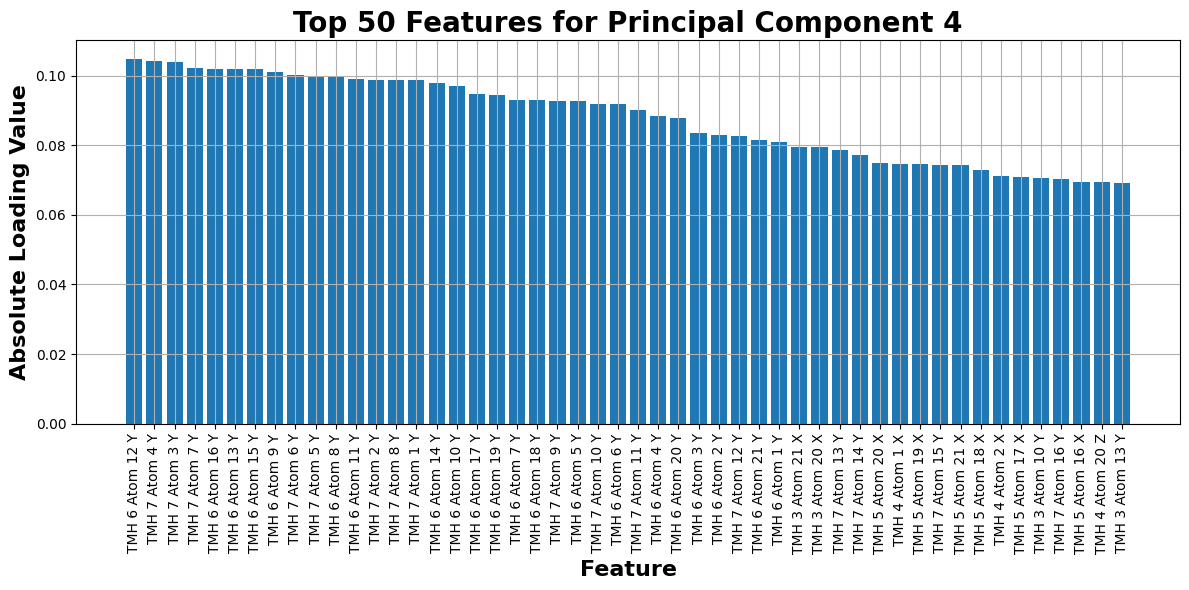

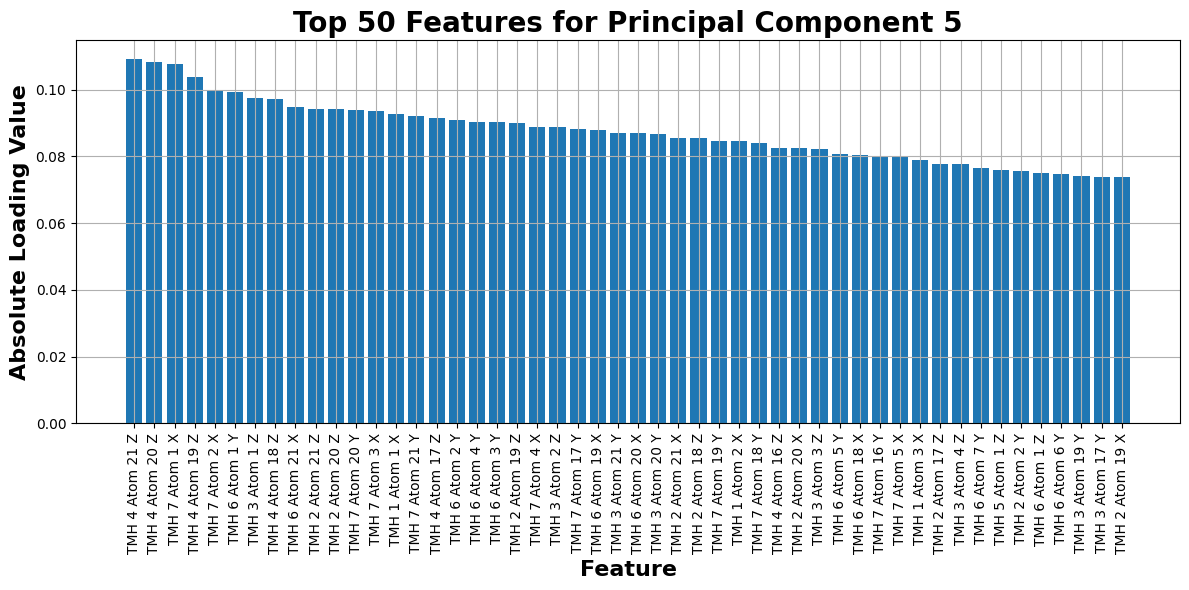

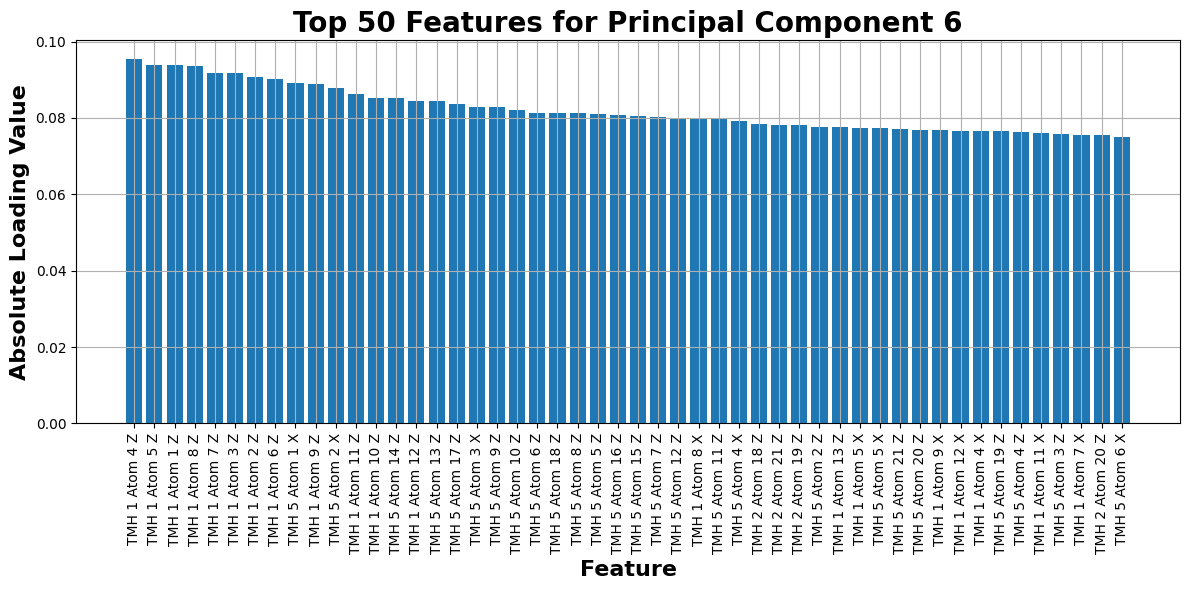

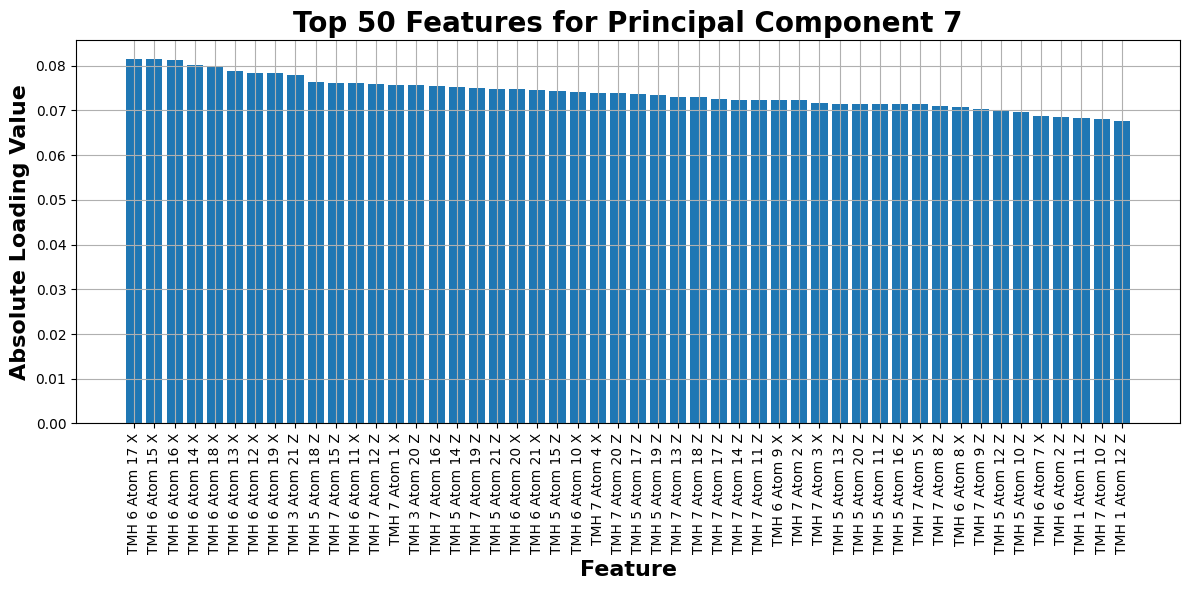

In [23]:
top_n = 50
feature_names = final_features_df.columns

abs_loadings = np.abs(pca.components_)

# For each factor, select the top N features based on their absolute loadings
for i in range(pca.components_.shape[0]):
    top_indices = np.argsort(abs_loadings[i])[::-1][:top_n]
    
    if len(top_indices) > 0:
        plt.figure(figsize=(12, 6))
    
        top_feature_names = feature_names[top_indices]
        
        plt.bar(top_feature_names, abs_loadings[i, top_indices])
        
        plt.title(f"Top {top_n} Features for Principal Component {i+1}", fontsize=20, fontweight='bold')
        plt.xlabel("Feature", fontsize=16, fontweight='bold')
        plt.ylabel("Absolute Loading Value", fontsize=16, fontweight='bold')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No top {top_n} features for Factor {i+1}")

In [24]:
top_features_dict = {f"PC{i+1}": [] for i in range(pca.components_.shape[0])}

# For each factor, select the top N features based on their absolute loadings
for i in range(pca.components_.shape[0]):
    top_indices = np.argsort(abs_loadings[i])[::-1][:top_n]
    
    top_feature_names = feature_names[top_indices]
    top_loading_values = abs_loadings[i, top_indices]
    
    top_features_dict[f"PC{i+1}"] = list(zip(top_feature_names, top_loading_values))

top_features_df = pd.DataFrame(top_features_dict)
top_features_expanded = {}
for pc in range(pca.components_.shape[0]):
    top_features_expanded[f"PC{pc+1}"] = [f"{feature}: {loading:5f}" for feature, loading in top_features_dict[f"PC{pc+1}"]]

top_features_final_df = pd.DataFrame(top_features_expanded)
top_features_final_df.index = [f"Feature {i+1}" for i in range(top_n)]
top_features_final_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Feature 1,TMH 3 Atom 13 Z: 0.062623,TMH 1 Atom 12 Y: 0.113131,TMH 4 Atom 3 Y: 0.124226,TMH 6 Atom 12 Y: 0.104922,TMH 4 Atom 21 Z: 0.109336,TMH 1 Atom 4 Z: 0.095544,TMH 6 Atom 17 X: 0.081586
Feature 2,TMH 3 Atom 12 Z: 0.062453,TMH 1 Atom 11 Y: 0.112137,TMH 4 Atom 6 Y: 0.123983,TMH 7 Atom 4 Y: 0.104361,TMH 4 Atom 20 Z: 0.108450,TMH 1 Atom 5 Z: 0.093891,TMH 6 Atom 15 X: 0.081423
Feature 3,TMH 3 Atom 10 X: 0.062408,TMH 5 Atom 12 Y: 0.112025,TMH 4 Atom 4 Y: 0.123778,TMH 7 Atom 3 Y: 0.104005,TMH 7 Atom 1 X: 0.107835,TMH 1 Atom 1 Z: 0.093829,TMH 6 Atom 16 X: 0.081263
Feature 4,TMH 3 Atom 14 Z: 0.062403,TMH 5 Atom 8 Y: 0.111479,TMH 4 Atom 7 Y: 0.123650,TMH 7 Atom 7 Y: 0.102211,TMH 4 Atom 19 Z: 0.103708,TMH 1 Atom 8 Z: 0.093574,TMH 6 Atom 14 X: 0.080105
Feature 5,TMH 3 Atom 11 Z: 0.062381,TMH 1 Atom 13 Y: 0.111307,TMH 4 Atom 5 Y: 0.123576,TMH 6 Atom 16 Y: 0.101954,TMH 7 Atom 2 X: 0.099936,TMH 1 Atom 7 Z: 0.091884,TMH 6 Atom 18 X: 0.079673
Feature 6,TMH 3 Atom 10 Z: 0.062307,TMH 1 Atom 15 Y: 0.111204,TMH 4 Atom 8 Y: 0.123316,TMH 6 Atom 13 Y: 0.101862,TMH 6 Atom 1 Y: 0.099246,TMH 1 Atom 3 Z: 0.091779,TMH 6 Atom 13 X: 0.078778
Feature 7,TMH 3 Atom 9 X: 0.062225,TMH 5 Atom 11 Y: 0.111175,TMH 4 Atom 2 Y: 0.123291,TMH 6 Atom 15 Y: 0.101845,TMH 3 Atom 1 Z: 0.097671,TMH 1 Atom 2 Z: 0.090594,TMH 6 Atom 12 X: 0.078376
Feature 8,TMH 3 Atom 11 X: 0.061935,TMH 5 Atom 15 Y: 0.110956,TMH 4 Atom 9 Y: 0.122909,TMH 6 Atom 9 Y: 0.101131,TMH 4 Atom 18 Z: 0.097263,TMH 1 Atom 6 Z: 0.090176,TMH 6 Atom 19 X: 0.078374
Feature 9,TMH 3 Atom 15 Z: 0.061792,TMH 1 Atom 16 Y: 0.110536,TMH 4 Atom 1 Y: 0.122605,TMH 7 Atom 6 Y: 0.100246,TMH 6 Atom 21 X: 0.094954,TMH 5 Atom 1 X: 0.089265,TMH 3 Atom 21 Z: 0.077887
Feature 10,TMH 3 Atom 8 X: 0.061707,TMH 5 Atom 9 Y: 0.110499,TMH 4 Atom 10 Y: 0.122468,TMH 7 Atom 5 Y: 0.099891,TMH 2 Atom 21 Z: 0.094361,TMH 1 Atom 9 Z: 0.088820,TMH 5 Atom 18 Z: 0.076294


# Factor Analysis

## On the original features

In [25]:
fa = FactorAnalysis(n_components=best_n_components)
fa_result = fa.fit_transform(final_features_df)

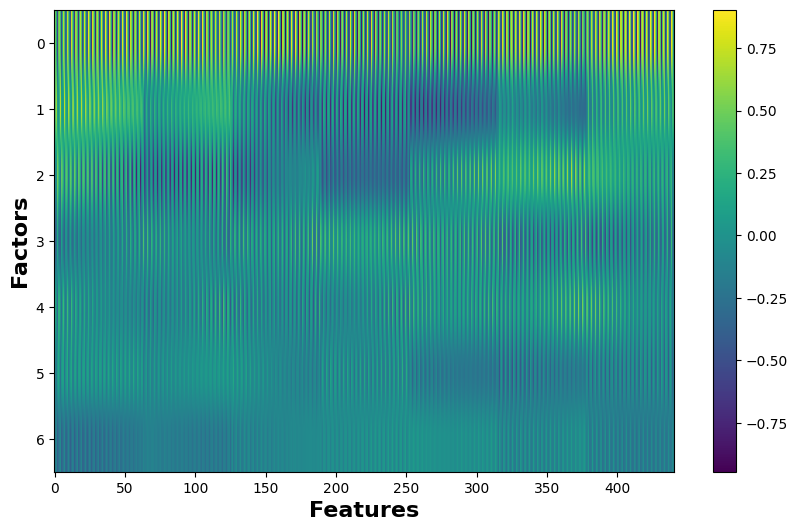

In [26]:
plt.figure(figsize=(10, 6))
plt.imshow(fa.components_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.ylabel('Factors', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=16, fontweight='bold')
plt.show()

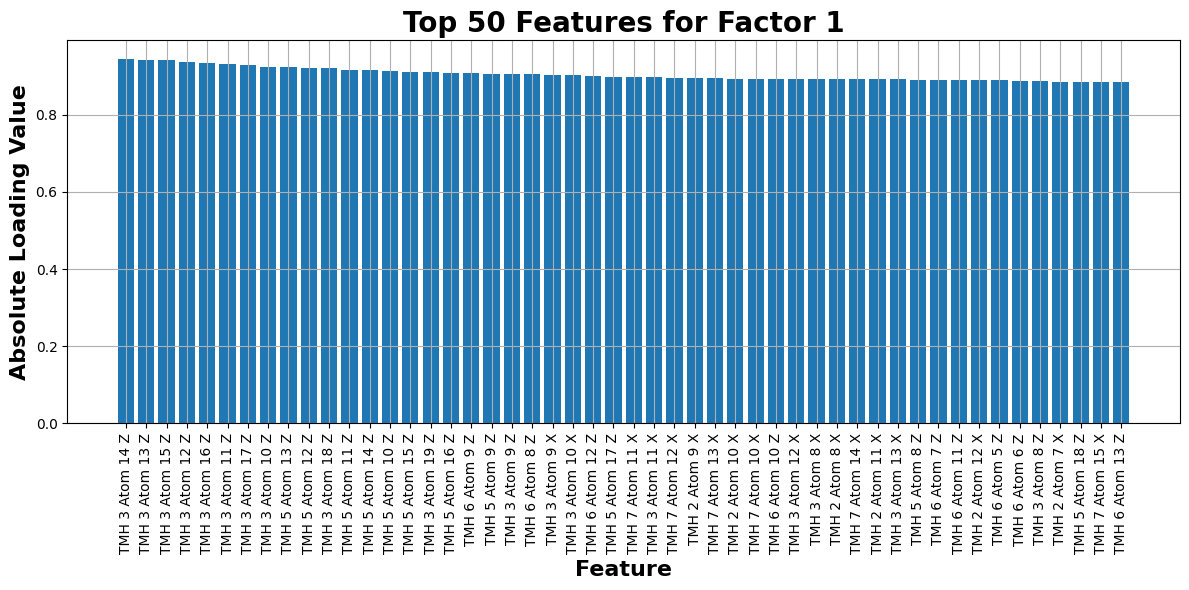

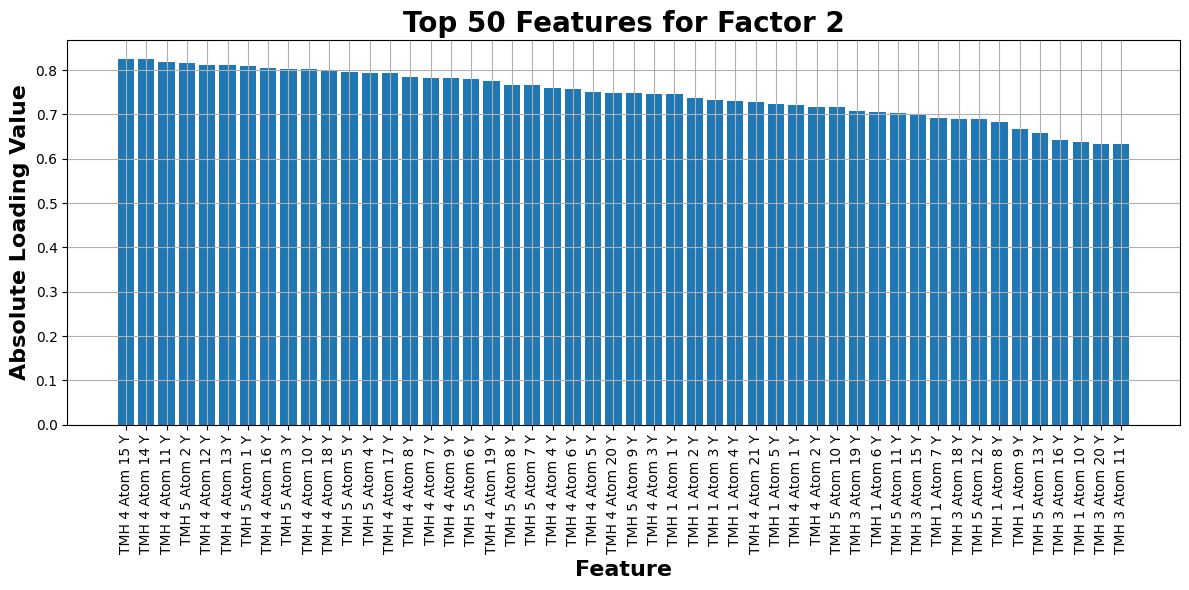

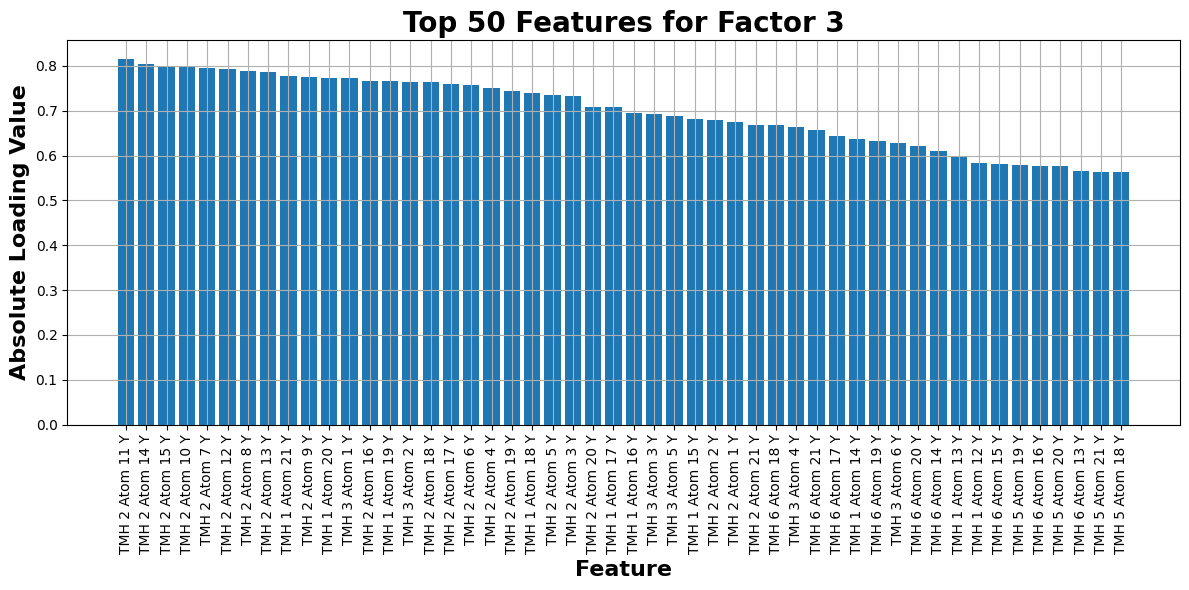

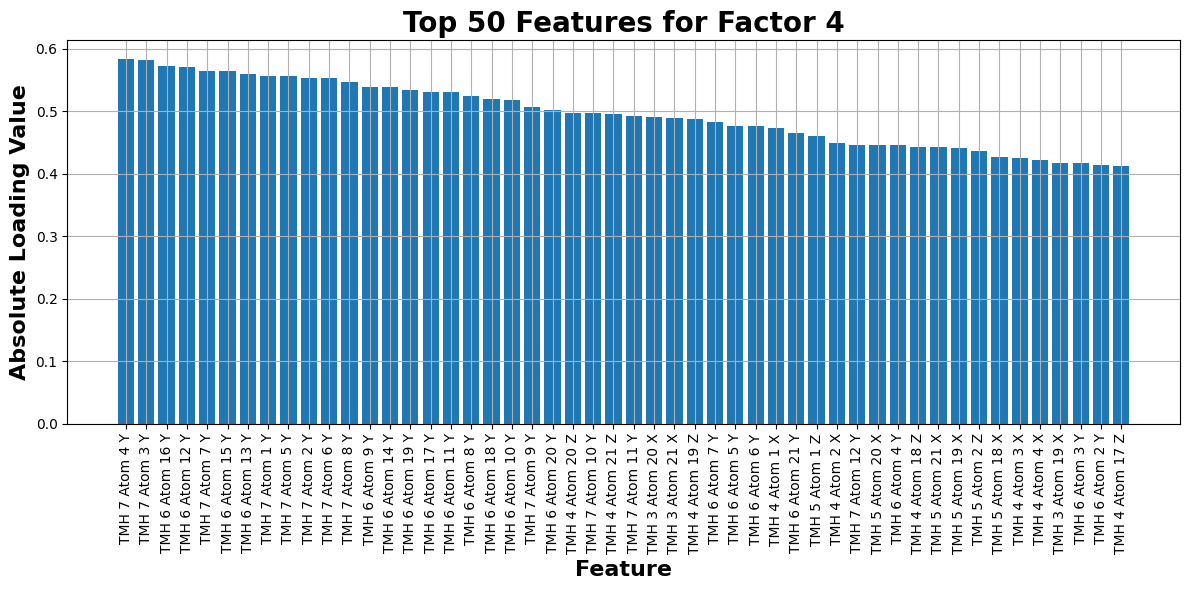

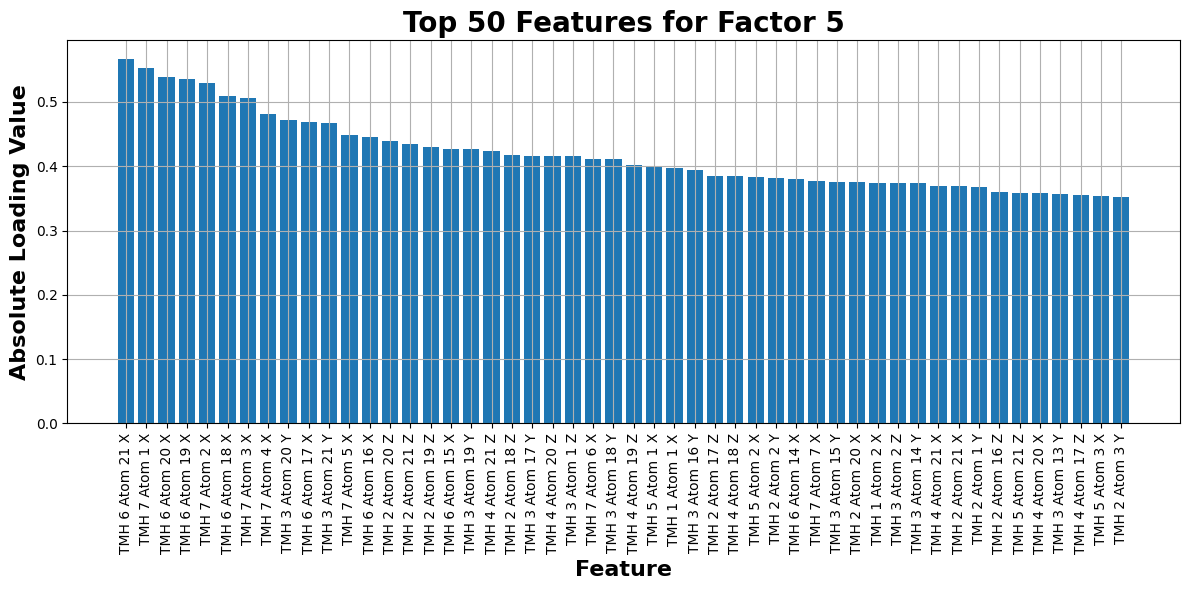

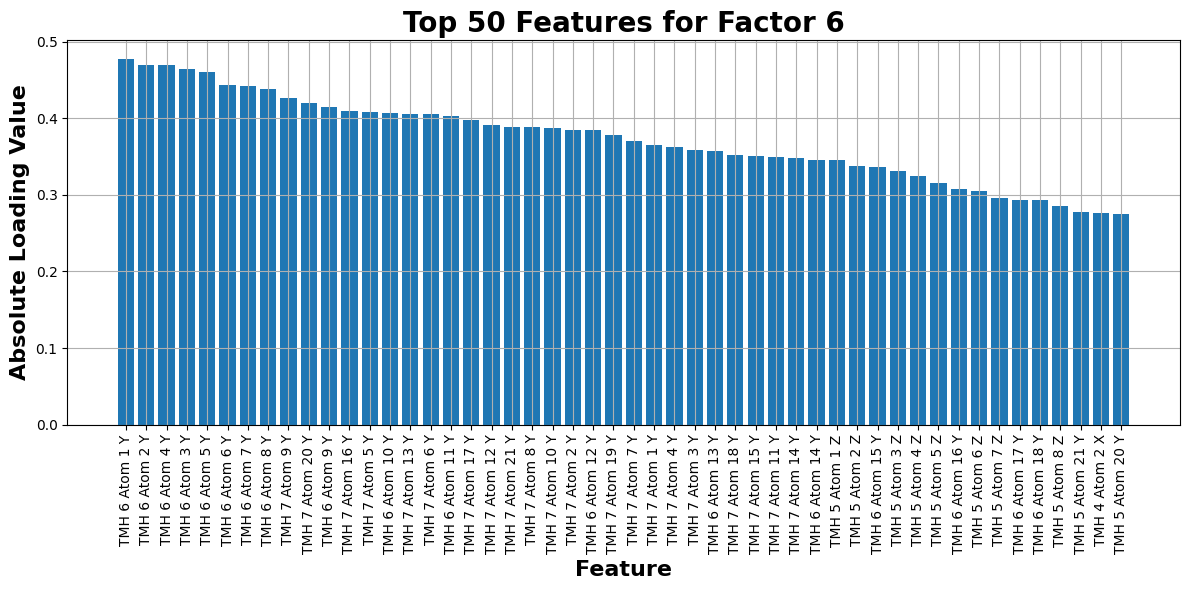

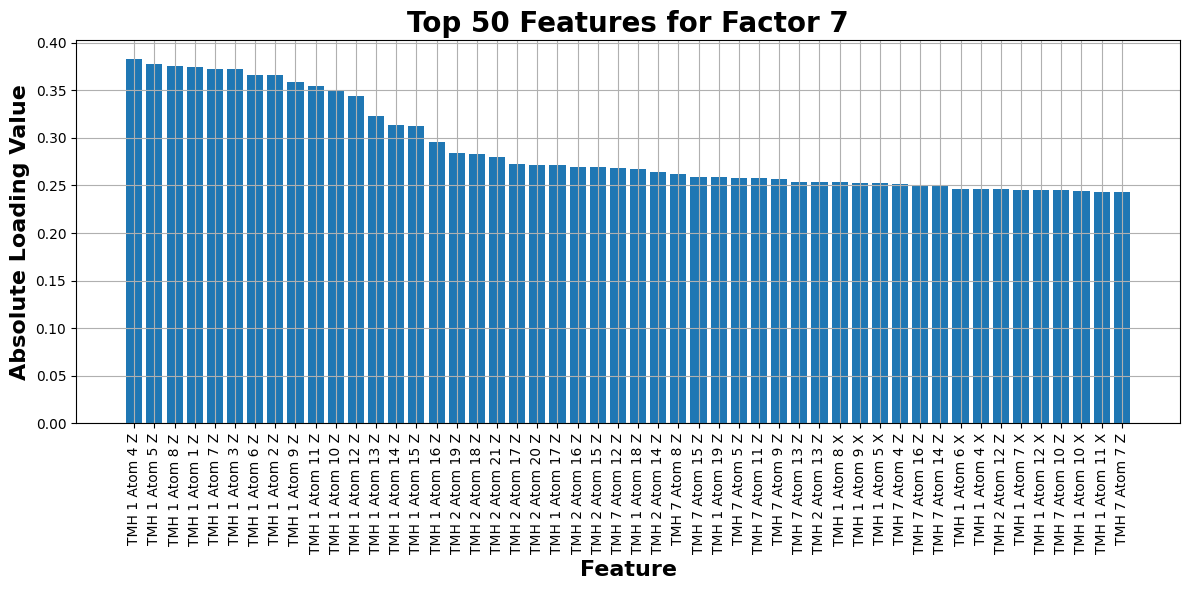

In [27]:
top_n = 50
feature_names = final_features_df.columns

abs_loadings_fa = np.abs(fa.components_)

# For each factor, select the top N features based on their absolute loadings
for i in range(fa.components_.shape[0]):
    top_indices = np.argsort(abs_loadings_fa[i])[::-1][:top_n]
    
    if len(top_indices) > 0:
        plt.figure(figsize=(12, 6))
        
        top_feature_names = feature_names[top_indices]
        
        plt.bar(top_feature_names, abs_loadings_fa[i, top_indices])
        
        plt.title(f"Top {top_n} Features for Factor {i+1}", fontsize=20, fontweight='bold')
        plt.xlabel("Feature", fontsize=16, fontweight='bold')
        plt.ylabel("Absolute Loading Value", fontsize=16, fontweight='bold')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No top {top_n} features for Factor {i+1}")

In [28]:
top_features_dict_fa = {f"Factor{i+1}": [] for i in range(fa.components_.shape[0])}

# For each factor, select the top N features based on their absolute loadings
for i in range(fa.components_.shape[0]):
    top_indices = np.argsort(abs_loadings_fa[i])[::-1][:top_n]
    
    top_feature_names = feature_names[top_indices]
    top_loading_values = abs_loadings_fa[i, top_indices]
    
    top_features_dict_fa[f"Factor{i+1}"] = list(zip(top_feature_names, top_loading_values))

top_features_df_fa = pd.DataFrame(top_features_dict_fa)
top_features_expanded_fa = {}
for fa in range(fa.components_.shape[0]):
    top_features_expanded_fa[f"Factor{fa+1}"] = [f"{feature}: {loading:5f}" for feature, loading in top_features_dict_fa[f"Factor{fa+1}"]]

top_features_final_df_fa = pd.DataFrame(top_features_expanded_fa)
top_features_final_df_fa.index = [f"Feature {i+1}" for i in range(top_n)]
top_features_final_df_fa

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
Feature 1,TMH 3 Atom 14 Z: 0.945468,TMH 4 Atom 15 Y: 0.826017,TMH 2 Atom 11 Y: 0.816287,TMH 7 Atom 4 Y: 0.584078,TMH 6 Atom 21 X: 0.567364,TMH 6 Atom 1 Y: 0.478076,TMH 1 Atom 4 Z: 0.383240
Feature 2,TMH 3 Atom 13 Z: 0.941855,TMH 4 Atom 14 Y: 0.825724,TMH 2 Atom 14 Y: 0.804859,TMH 7 Atom 3 Y: 0.581244,TMH 7 Atom 1 X: 0.552884,TMH 6 Atom 2 Y: 0.469524,TMH 1 Atom 5 Z: 0.377184
Feature 3,TMH 3 Atom 15 Z: 0.941380,TMH 4 Atom 11 Y: 0.818109,TMH 2 Atom 15 Y: 0.800062,TMH 6 Atom 16 Y: 0.571497,TMH 6 Atom 20 X: 0.539114,TMH 6 Atom 4 Y: 0.469340,TMH 1 Atom 8 Z: 0.375909
Feature 4,TMH 3 Atom 12 Z: 0.935511,TMH 5 Atom 2 Y: 0.815723,TMH 2 Atom 10 Y: 0.798985,TMH 6 Atom 12 Y: 0.570135,TMH 6 Atom 19 X: 0.536309,TMH 6 Atom 3 Y: 0.464935,TMH 1 Atom 1 Z: 0.374083
Feature 5,TMH 3 Atom 16 Z: 0.934087,TMH 4 Atom 12 Y: 0.811232,TMH 2 Atom 7 Y: 0.795659,TMH 7 Atom 7 Y: 0.564615,TMH 7 Atom 2 X: 0.529273,TMH 6 Atom 5 Y: 0.460277,TMH 1 Atom 7 Z: 0.372711
Feature 6,TMH 3 Atom 11 Z: 0.931293,TMH 4 Atom 13 Y: 0.811211,TMH 2 Atom 12 Y: 0.793106,TMH 6 Atom 15 Y: 0.564410,TMH 6 Atom 18 X: 0.509482,TMH 6 Atom 6 Y: 0.443543,TMH 1 Atom 3 Z: 0.372479
Feature 7,TMH 3 Atom 17 Z: 0.929494,TMH 5 Atom 1 Y: 0.810364,TMH 2 Atom 8 Y: 0.789221,TMH 6 Atom 13 Y: 0.558764,TMH 7 Atom 3 X: 0.506284,TMH 6 Atom 7 Y: 0.442561,TMH 1 Atom 6 Z: 0.366475
Feature 8,TMH 3 Atom 10 Z: 0.923439,TMH 4 Atom 16 Y: 0.805480,TMH 2 Atom 13 Y: 0.785825,TMH 7 Atom 1 Y: 0.556028,TMH 7 Atom 4 X: 0.481637,TMH 6 Atom 8 Y: 0.437883,TMH 1 Atom 2 Z: 0.366447
Feature 9,TMH 5 Atom 13 Z: 0.922469,TMH 5 Atom 3 Y: 0.802200,TMH 1 Atom 21 Y: 0.778030,TMH 7 Atom 5 Y: 0.555881,TMH 3 Atom 20 Y: 0.471430,TMH 7 Atom 9 Y: 0.426100,TMH 1 Atom 9 Z: 0.359151
Feature 10,TMH 5 Atom 12 Z: 0.922303,TMH 4 Atom 10 Y: 0.802019,TMH 2 Atom 9 Y: 0.775618,TMH 7 Atom 2 Y: 0.553394,TMH 6 Atom 17 X: 0.468315,TMH 7 Atom 20 Y: 0.419671,TMH 1 Atom 11 Z: 0.354202


## On the Principal Components

In [29]:
fa_pca = FactorAnalysis(n_components=best_n_components)
fa_pca_result = fa_pca.fit_transform(pca_result)

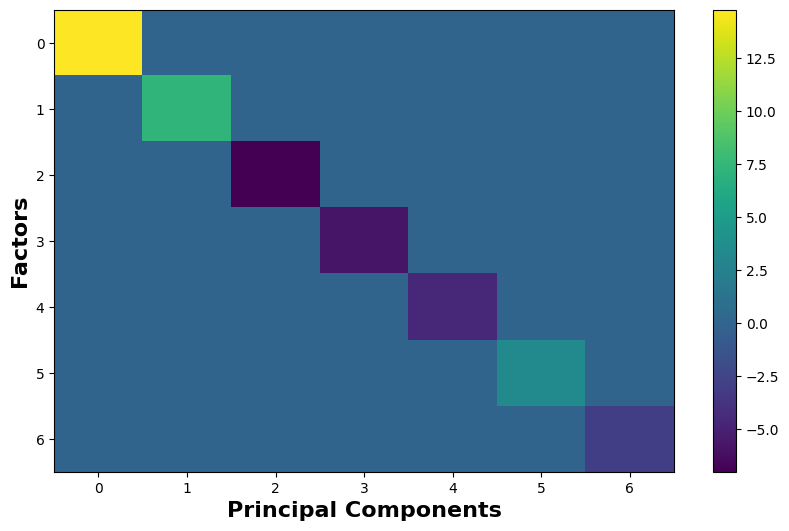

In [30]:
plt.figure(figsize=(10, 6))
plt.imshow(fa_pca.components_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.ylabel('Factors', fontsize=16, fontweight='bold')
plt.xlabel('Principal Components', fontsize=16, fontweight='bold')
plt.show()

# Supervised Learning

In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

## Using original features

In [32]:
y_df = final_targets_df['Class'].ravel()
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_df)
X_features = final_features_df

X_train_val, X_test, y_train_val, y_test = X_features[:-100], X_features[-100:], y_encoded[:-100], y_encoded[-100:]
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.4, random_state=42)

In [33]:
# Define models and parameter grids
models = {
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier()
}

param_grids = {
    'XGBoost': {
        'n_estimators': [10, 25, 50, 75, 100],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2, 0.5]
    },
    'Gradient Boosting': {
        'n_estimators': [10, 25, 50, 75, 100],
        'learning_rate': [0.01, 0.1, 0.2, 0.5],
        'max_depth': [3, 6, 10]
    },
    'Random Forest': {
        'n_estimators': [10, 25, 50, 75, 100],
        'max_depth': [3, 6, 10],
        'min_samples_split': [2, 5, 10]
    }
}

In [34]:
# GridSearchCV for each model
supervised_learning_models = pd.DataFrame()
result = {}

for model_name in models:
    start_time = time.time()
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=3, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    run_time = time.time() - start_time

    train_score = best_model.score(X_train, y_train)
    val_score = best_model.score(X_val, y_val)
    test_score = best_model.score(X_test, y_test)

    train_wt = 0.1
    valid_wt = 0.4
    test_wt = 0.5

    weighted_accuracy = train_wt*train_score + valid_wt*val_score + test_wt*test_score

    result = pd.DataFrame({
        'Model': [model_name],
        'Training Accuracy': [train_score],
        'Validation Accuracy': [val_score],
        'Test Accuracy': [test_score],
        'Weighted Accuracy': [weighted_accuracy],
        'Best Parameters': [best_params],
        'Run Time': [run_time]
    })
    supervised_learning_models = pd.concat([supervised_learning_models, result], ignore_index=True)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 45 candidates, totalling 135 fits


In [35]:
supervised_learning_models

,Model,Training Accuracy,Validation Accuracy,Test Accuracy,Weighted Accuracy,Best Parameters,Run Time
0,XGBoost,0.988827,0.541667,0.78,0.705549,"{'learning_rate': 0.5, 'max_depth': 3, 'n_esti...",18.105192
1,Gradient Boosting,0.988827,0.441667,0.69,0.620549,"{'learning_rate': 0.5, 'max_depth': 3, 'n_esti...",94.079067
2,Random Forest,0.966480,0.541667,0.79,0.708315,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.942885


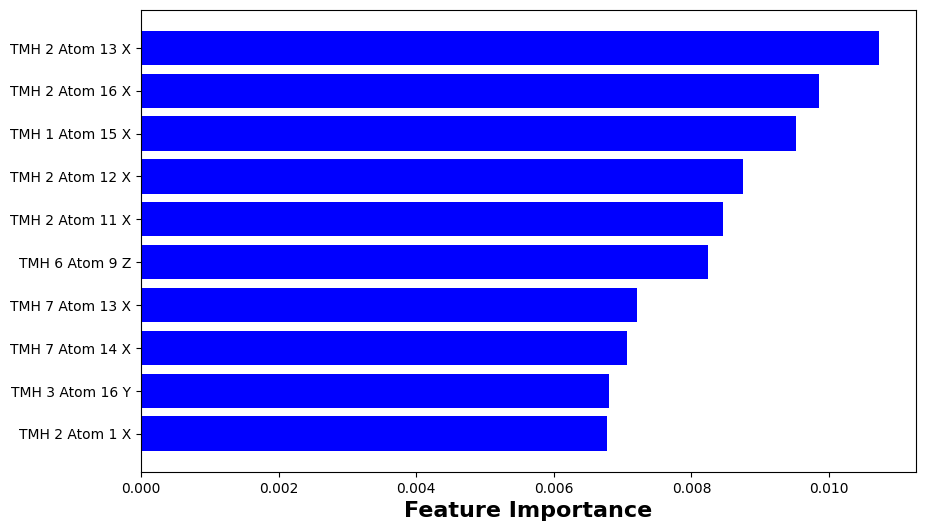

In [36]:
model = 'Random Forest' # based on the best model in the table

grid_search = GridSearchCV(models[model], param_grids[model], cv=3, n_jobs=-1, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
importances = best_rf.feature_importances_
feature_names = X_features.columns

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_importances[:10], color='blue')
plt.xlabel('Feature Importance', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

## Using Principal Components

In [37]:
X_features_pca = pca_result

X_train_val_pca, X_test_pca, y_train_val_pca, y_test_pca = X_features_pca[:-100], X_features_pca[-100:], y_encoded[:-100], y_encoded[-100:]
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_val_pca, y_train_val_pca, test_size=0.4, random_state=42)

In [38]:
# GridSearchCV for each model
supervised_learning_models_pca = pd.DataFrame()
result = {}

for model_name in models:
    start_time = time.time()
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=3, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')
    grid_search.fit(X_train_pca, y_train_pca)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    run_time = time.time() - start_time

    train_score = best_model.score(X_train_pca, y_train_pca)
    val_score = best_model.score(X_val_pca, y_val_pca)
    test_score = best_model.score(X_test_pca, y_test_pca)

    train_wt = 0.1
    valid_wt = 0.4
    test_wt = 0.5

    weighted_accuracy = train_wt*train_score + valid_wt*val_score + test_wt*test_score

    result = pd.DataFrame({
        'Model': [model_name],
        'Training Accuracy': [train_score],
        'Validation Accuracy': [val_score],
        'Test Accuracy': [test_score],
        'Weighted Accuracy': [weighted_accuracy],
        'Best Parameters': [best_params],
        'Run Time': [run_time]
    })
    supervised_learning_models_pca = pd.concat([supervised_learning_models_pca, result], ignore_index=True)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 45 candidates, totalling 135 fits


In [39]:
supervised_learning_models_pca

,Model,Training Accuracy,Validation Accuracy,Test Accuracy,Weighted Accuracy,Best Parameters,Run Time
0,XGBoost,0.966480,0.541667,0.73,0.678315,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.740474
1,Gradient Boosting,0.994413,0.491667,0.69,0.641108,"{'learning_rate': 0.5, 'max_depth': 3, 'n_esti...",6.631153
2,Random Forest,0.865922,0.516667,0.71,0.648259,"{'max_depth': 6, 'min_samples_split': 2, 'n_es...",0.575145


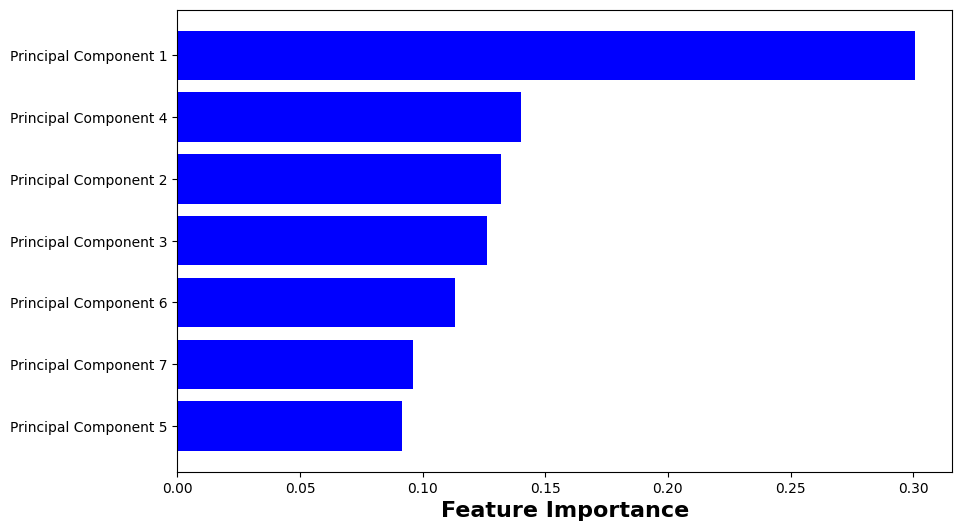

In [40]:
model = 'XGBoost' # based on the best model in the table

grid_search = GridSearchCV(models[model], param_grids[model], cv=3, n_jobs=-1, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_pca, y_train_pca)
best_rf = grid_search.best_estimator_
importances = best_rf.feature_importances_
feature_names = [f'Principal Component {i}' for i in range(1, 8)]

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='blue')
plt.xlabel('Feature Importance', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

## Using Factors

In [41]:
X_features_fa = fa_result

X_train_val_fa, X_test_fa, y_train_val_fa, y_test_fa = X_features_fa[:-100], X_features_fa[-100:], y_encoded[:-100], y_encoded[-100:]
X_train_fa, X_val_fa, y_train_fa, y_val_fa = train_test_split(X_train_val_fa, y_train_val_fa, test_size=0.4, random_state=42)

In [42]:
# GridSearchCV for each model
supervised_learning_models_fa = pd.DataFrame()
result = {}

for model_name in models:
    start_time = time.time()
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=3, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')
    grid_search.fit(X_train_fa, y_train_fa)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    run_time = time.time() - start_time

    train_score = best_model.score(X_train_fa, y_train_fa)
    val_score = best_model.score(X_val_fa, y_val_fa)
    test_score = best_model.score(X_test_fa, y_test_fa)

    train_wt = 0.1
    valid_wt = 0.4
    test_wt = 0.5

    weighted_accuracy = train_wt*train_score + valid_wt*val_score + test_wt*test_score

    result = pd.DataFrame({
        'Model': [model_name],
        'Training Accuracy': [train_score],
        'Validation Accuracy': [val_score],
        'Test Accuracy': [test_score],
        'Weighted Accuracy': [weighted_accuracy],
        'Best Parameters': [best_params],
        'Run Time': [run_time]
    })
    supervised_learning_models_fa = pd.concat([supervised_learning_models_fa, result], ignore_index=True)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 45 candidates, totalling 135 fits


In [43]:
supervised_learning_models_fa

,Model,Training Accuracy,Validation Accuracy,Test Accuracy,Weighted Accuracy,Best Parameters,Run Time
0,XGBoost,0.681564,0.525000,0.79,0.673156,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.906441
1,Gradient Boosting,0.798883,0.525000,0.79,0.684888,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",7.139282
2,Random Forest,0.782123,0.508333,0.72,0.641546,"{'max_depth': 6, 'min_samples_split': 2, 'n_es...",0.527051


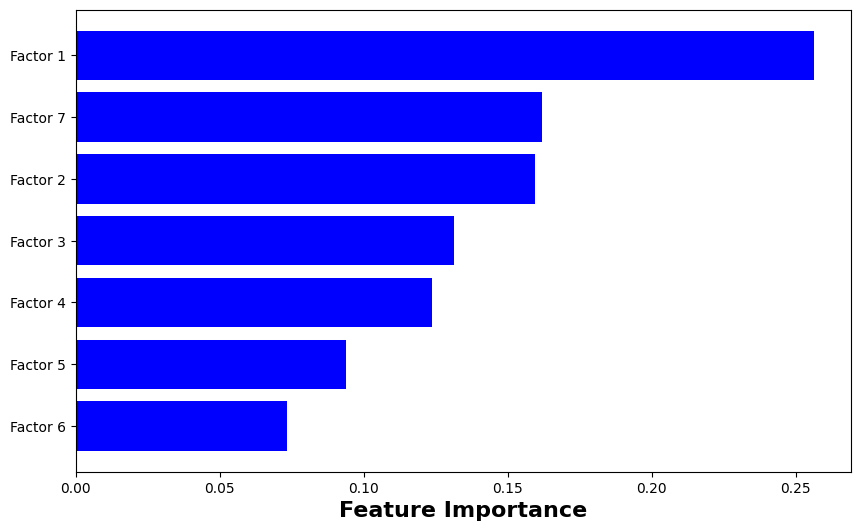

In [44]:
model = 'Random Forest' # based on the best model in the table

grid_search = GridSearchCV(models[model], param_grids[model], cv=3, n_jobs=-1, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_fa, y_train_fa)
best_rf = grid_search.best_estimator_
importances = best_rf.feature_importances_
feature_names = [f'Factor {i}' for i in range(1, 8)]

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='blue')
plt.xlabel('Feature Importance', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

# Unsupervised Learning

In [45]:
def find_optimal_clusters(df, max_clusters=10):
    # For KMeans
    kmeans_silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans_clusters = kmeans.fit_predict(df)
        kmeans_silhouette_scores.append(silhouette_score(df, kmeans_clusters))

    optimal_kmeans_clusters = np.argmax(kmeans_silhouette_scores) + 2

    # For Agglomerative Clustering
    agglo_silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        agglo = AgglomerativeClustering(n_clusters=n_clusters)
        agglo_clusters = agglo.fit_predict(df)
        agglo_silhouette_scores.append(silhouette_score(df, agglo_clusters))

    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), kmeans_silhouette_scores, marker='o', linestyle='--', color='g', label='KMeans')
    plt.plot(range(2, max_clusters + 1), agglo_silhouette_scores, marker='o', linestyle='--', color='r', label='Hierarchical')
    plt.xlabel("Number of Clusters", fontsize=16, fontweight='bold')
    plt.ylabel("Silhouette Score", fontsize=16, fontweight='bold')
    plt.legend()
    plt.show()

    optimal_agglo_clusters = np.argmax(agglo_silhouette_scores) + 2

    # For DBSCAN
    eps_values = np.arange(0.1, 2.1, 0.1)
    min_samples_values = range(3, 10)
    dbscan_silhouette_scores = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_clusters = dbscan.fit_predict(df)
            
            # Ignore the noise points (labeled as -1 in DBSCAN)
            if len(set(dbscan_clusters)) > 1:
                score = silhouette_score(df, dbscan_clusters)
                dbscan_silhouette_scores.append((eps, min_samples, score))
    
    dbscan_eps_values = [score[0] for score in dbscan_silhouette_scores]
    dbscan_min_samples_values = [score[1] for score in dbscan_silhouette_scores]
    dbscan_scores = [score[2] for score in dbscan_silhouette_scores]
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(dbscan_eps_values, dbscan_min_samples_values, c=dbscan_scores, cmap='viridis')
    plt.colorbar(scatter, label='Silhouette Score')
    plt.xlabel("eps", fontsize=16, fontweight='bold')
    plt.ylabel("min_samples", fontsize=16, fontweight='bold')
    plt.show()

    best_dbscan_params = max(dbscan_silhouette_scores, key=lambda x: x[2], default=None)

    print(f"Optimal number of clusters for KMeans: {optimal_kmeans_clusters}")
    print(f"Optimal number of clusters for Agglomerative Clustering: {optimal_agglo_clusters}")
    if best_dbscan_params:
        print(f"Optimal DBSCAN parameters: eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}")
    else:
        print("No suitable DBSCAN clustering found.")

    return optimal_kmeans_clusters, optimal_agglo_clusters, best_dbscan_params

In [46]:
def perform_clustering(df, optimal_kmeans, optimal_hierarchical, optimal_dbscan):
    kmeans = KMeans(n_clusters=optimal_kmeans)
    kmeans_clusters = kmeans.fit_predict(df)
    
    hierarchical = AgglomerativeClustering(n_clusters=optimal_hierarchical)
    hierarchical_clusters = hierarchical.fit_predict(df)
    
    dbscan = DBSCAN(eps=optimal_dbscan[0], min_samples=optimal_dbscan[1])
    dbscan_clusters = dbscan.fit_predict(df)

    links = sch.linkage(df, method='ward')

    return kmeans_clusters, hierarchical_clusters, dbscan_clusters, links

In [47]:
def plot_and_cluster(df, kmeans_clusters, hierarchical_clusters, dbscan_clusters, links, label=''):
    print('K-means Clustering')
    plt.figure(figsize=(10, 7))
    # unique_clusters = np.unique(kmeans_clusters)
    # for cluster in unique_clusters:
    #     cluster_data = df[kmeans_clusters == cluster]
    #     plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster+1}')
    plt.scatter(df[:, 0], df[:, 1], c=kmeans_clusters, cmap='viridis')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    plt.colorbar()
    # plt.legend()
    plt.show()

    print('Agglomerative Clustering')
    plt.figure(figsize=(10, 7))
    # unique_clusters_h = np.unique(hierarchical_clusters)
    # for cluster in unique_clusters_h:
    #     cluster_data_h = df[hierarchical_clusters == cluster]
    #     plt.scatter(cluster_data_h[:, 0], cluster_data_h[:, 1], label=f'Cluster {cluster+1}')
    plt.scatter(df[:, 0], df[:, 1], c=hierarchical_clusters, cmap='coolwarm')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    plt.colorbar()
    # plt.legend()
    plt.show()

    print('DBSCAN Clustering')
    plt.figure(figsize=(10, 7))
    # unique_clusters_db = np.unique(dbscan_clusters)
    # for cluster in unique_clusters_db:
    #     cluster_data_db = df[dbscan_clusters == cluster]
    #     plt.scatter(cluster_data_db[:, 0], cluster_data_db[:, 1], label=f'Cluster {cluster+1}')
    plt.scatter(df[:, 0], df[:, 1], c=dbscan_clusters, cmap='plasma')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    plt.colorbar()
    # plt.legend()
    plt.show()

    plt.figure(figsize=(10, 7))
    sch.dendrogram(links)
    plt.xticks([])
    plt.xlabel('Samples', fontsize=16, fontweight='bold')
    plt.ylabel('Distance', fontsize=16, fontweight='bold')
    plt.show()

## Using Principal Components

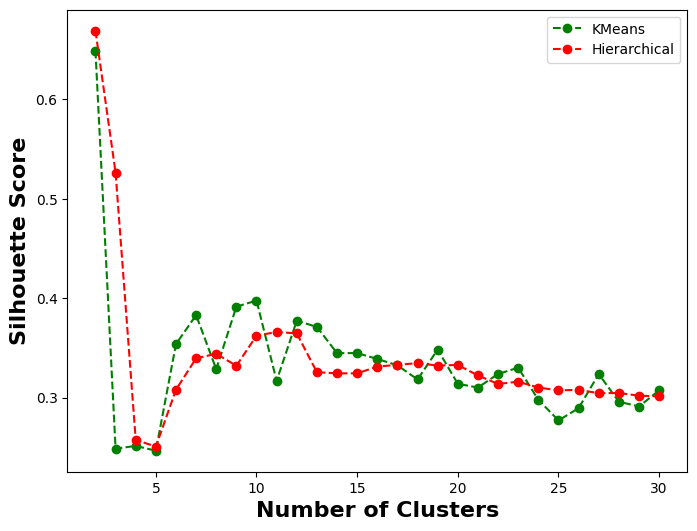

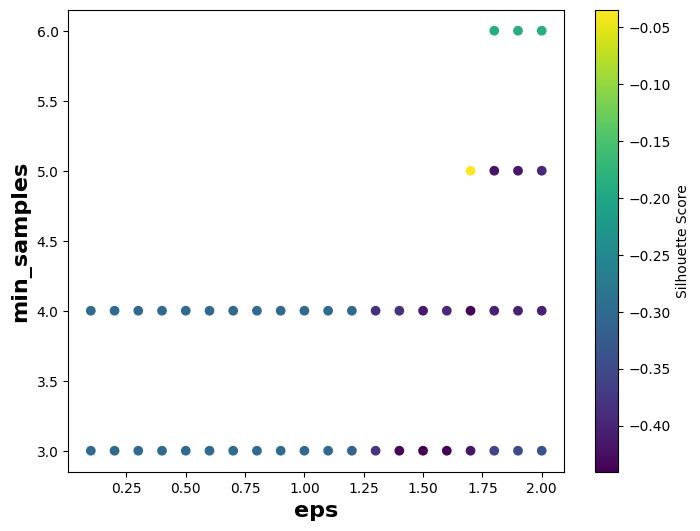

Optimal number of clusters for KMeans: 2
Optimal number of clusters for Agglomerative Clustering: 2
Optimal DBSCAN parameters: eps=1.7000000000000002, min_samples=5


In [48]:
optimal_kmeans_clusters_pca, optimal_agglo_clusters_pca, best_dbscan_params_pca = find_optimal_clusters(pca_result, max_clusters=30)

In [49]:
kmeans_clusters_pca, agglo_clusters_pca, dbscan_clusters_pca, links_pca = perform_clustering(pca_result, optimal_kmeans_clusters_pca, optimal_agglo_clusters_pca, best_dbscan_params_pca)

K-means Clustering


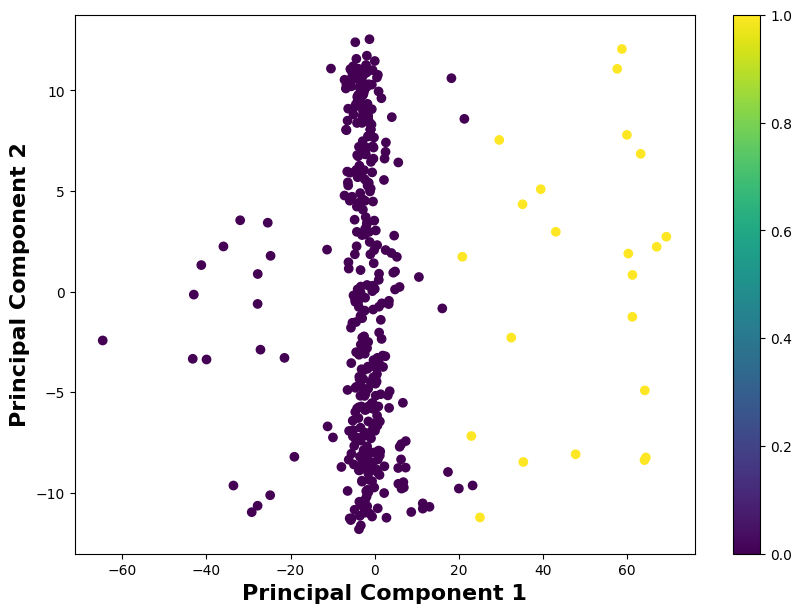

Agglomerative Clustering


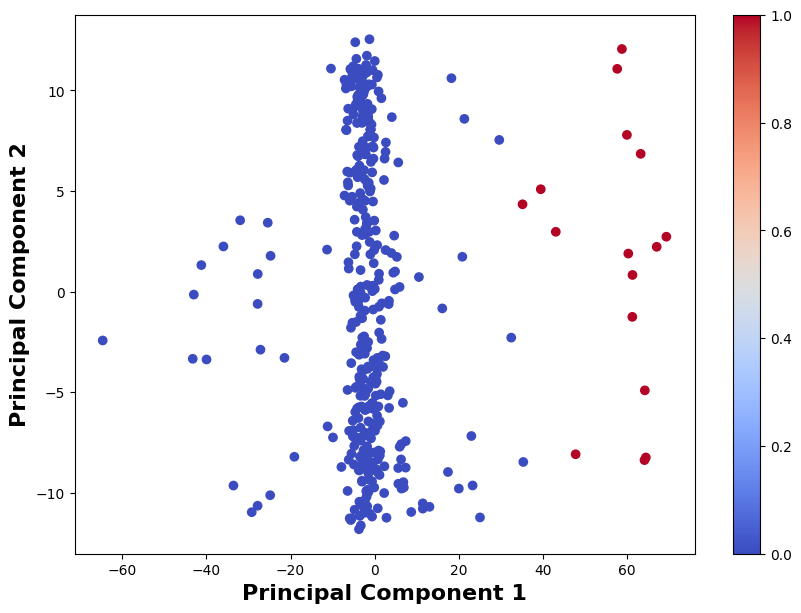

DBSCAN Clustering


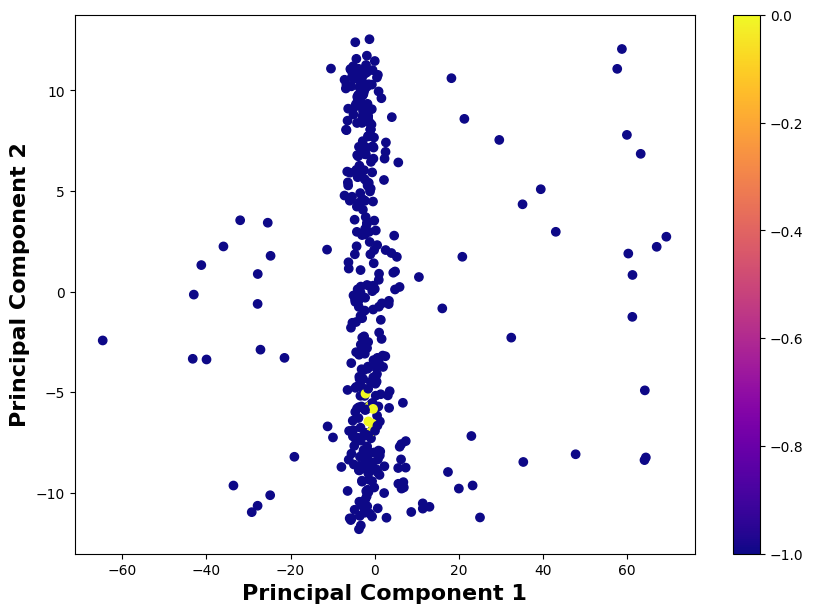

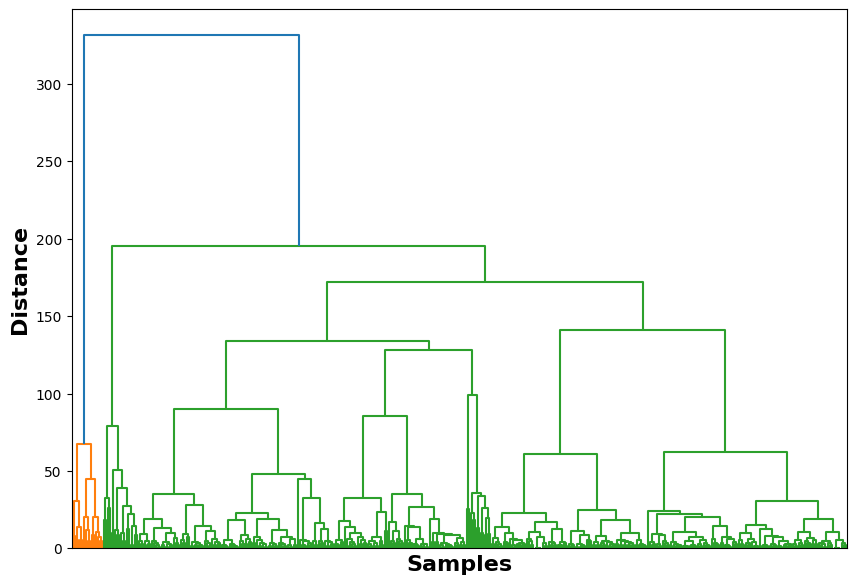

In [50]:
plot_and_cluster(pca_result, kmeans_clusters_pca, agglo_clusters_pca, dbscan_clusters_pca, links_pca, label='Principal Component')

## Using Factors

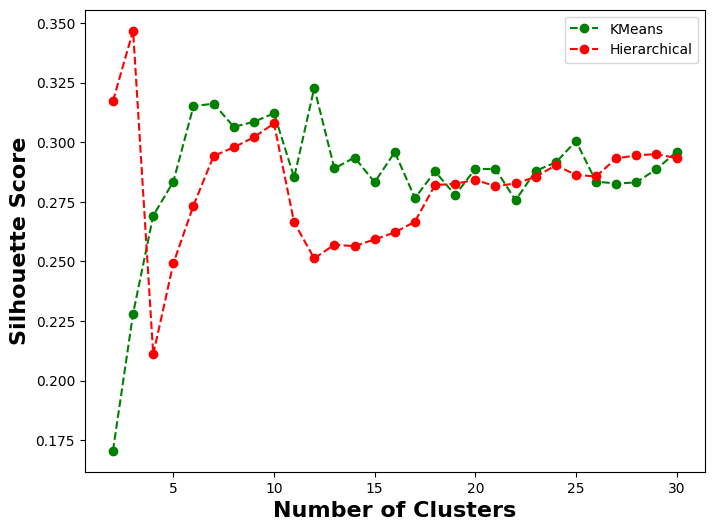

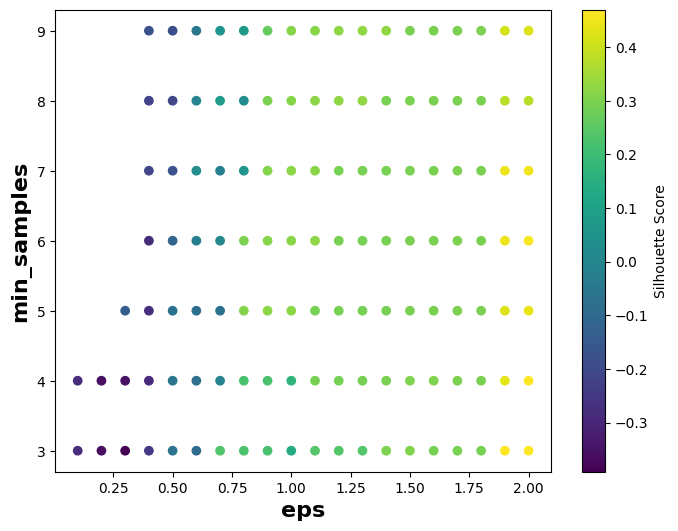

Optimal number of clusters for KMeans: 12
Optimal number of clusters for Agglomerative Clustering: 3
Optimal DBSCAN parameters: eps=1.9000000000000001, min_samples=3


In [51]:
optimal_kmeans_clusters_fa, optimal_agglo_clusters_fa, best_dbscan_params_fa = find_optimal_clusters(fa_result, max_clusters=30)

In [52]:
kmeans_clusters_fa, agglo_clusters_fa, dbscan_clusters_fa, links_fa = perform_clustering(fa_result, optimal_kmeans_clusters_fa, optimal_agglo_clusters_fa, best_dbscan_params_fa)

K-means Clustering


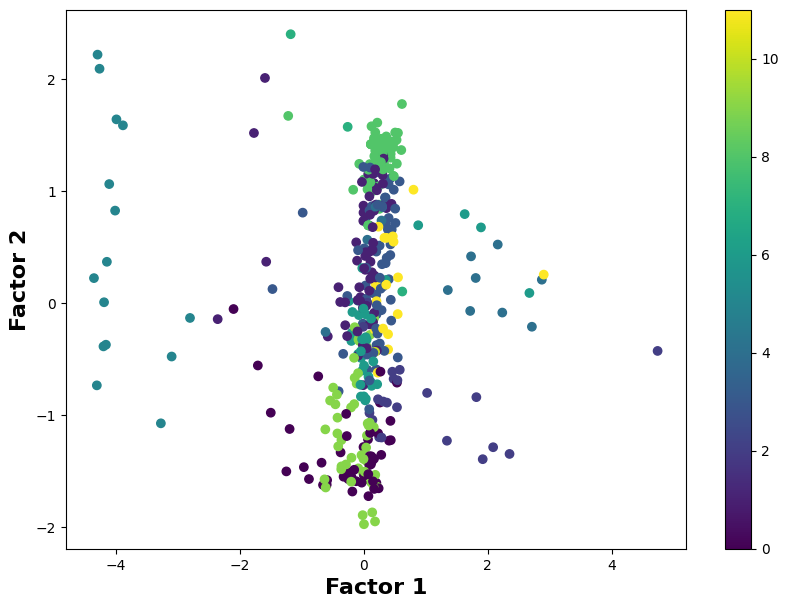

Agglomerative Clustering


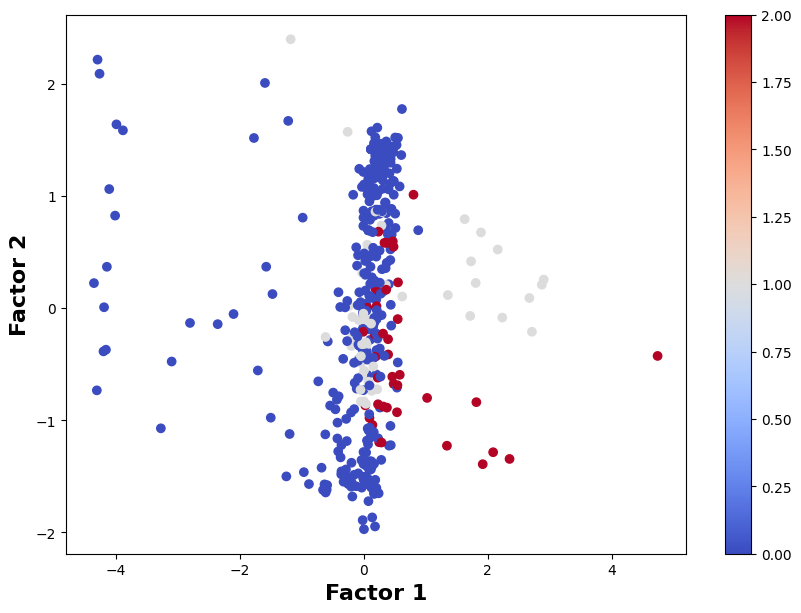

DBSCAN Clustering


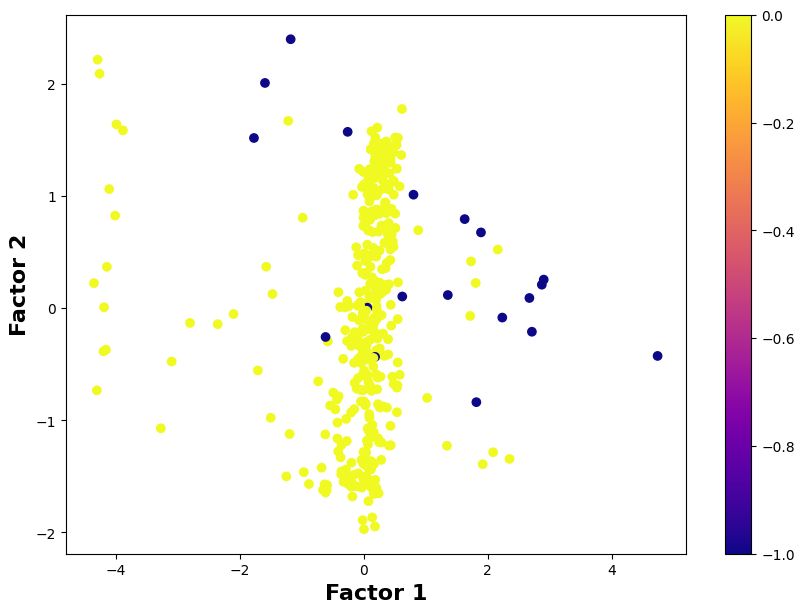

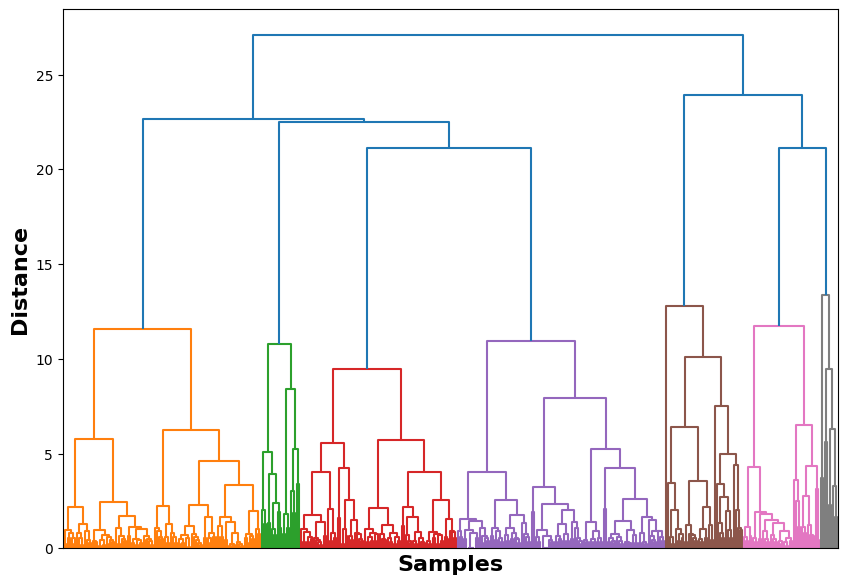

In [53]:
plot_and_cluster(fa_result, kmeans_clusters_fa, agglo_clusters_fa, dbscan_clusters_fa, links_fa, label='Factor')

## Combined Clustering Methods

In [54]:
kmeans_results_pca = pd.DataFrame({
    'protein': final_targets_df['protein'],
    'K-means Cluster PCA': kmeans_clusters_pca
})

agglo_results_pca = pd.DataFrame({
    'protein': final_targets_df['protein'],
    'Agglomerative Cluster PCA': agglo_clusters_pca
})

dbscan_results_pca = pd.DataFrame({
    'protein': final_targets_df['protein'],
    'DBSCAN Cluster PCA': dbscan_clusters_pca
})

threshold = 15
hierarchical_labels_pca = fcluster(links_pca, threshold, criterion='distance')
hierarchical_results_pca = pd.DataFrame({
    'protein': final_targets_df['protein'],
    'Hierarchical Cluster PCA': hierarchical_labels_pca
})

kmeans_results_fa = pd.DataFrame({
    'protein': final_targets_df['protein'],
    'K-means Cluster PCA': kmeans_clusters_fa
})

agglo_results_fa = pd.DataFrame({
    'protein': final_targets_df['protein'],
    'Agglomerative Cluster PCA': agglo_clusters_fa
})

dbscan_results_fa = pd.DataFrame({
    'protein': final_targets_df['protein'],
    'DBSCAN Cluster PCA': dbscan_clusters_fa
})

threshold = 15
hierarchical_labels_fa = fcluster(links_fa, threshold, criterion='distance')
hierarchical_results_fa = pd.DataFrame({
    'protein': final_targets_df['protein'],
    'Hierarchical Cluster PCA': hierarchical_labels_fa
})

clustering_summary = kmeans_results_pca.merge(agglo_results_pca, on='protein', how='outer') \
                               .merge(dbscan_results_pca, on='protein', how='outer') \
                               .merge(hierarchical_results_pca, on='protein', how='outer') \
                               .merge(agglo_results_fa, on='protein', how='outer') \
                               .merge(dbscan_results_fa, on='protein', how='outer') \
                               .merge(hierarchical_results_fa, on='protein', how='outer') \
                               .merge(final_targets_df, on='protein', how='outer')

In [55]:
clustering_summary

,protein,K-means Cluster PCA,Agglomerative Cluster PCA_x,DBSCAN Cluster PCA_x,Hierarchical Cluster PCA_x,Agglomerative Cluster PCA_y,DBSCAN Cluster PCA_y,Hierarchical Cluster PCA_y,Family id,Class
0,O00144,0,0,-1,26,0,0,1,25,Frizzled
1,O00155,0,0,-1,34,2,0,5,16,Orphan A
2,O00222,1,1,-1,6,0,0,2,40,C
3,O00254,0,0,-1,53,0,0,1,59,A
4,O00270,0,0,-1,51,0,0,3,16,Orphan A
...,...,...,...,...,...,...,...,...,...,...
394,Q9Y5N1,0,0,-1,56,0,0,4,33,A
395,Q9Y5X5,0,0,-1,52,0,0,1,43,A
396,Q9Y5Y3,0,0,-1,32,1,0,6,16,Orphan A
397,Q9Y5Y4,0,0,-1,17,0,0,3,58,A


# References

- Weis, W. I., & Kobilka, B. K. (2008). Structural insights into G-protein-coupled receptor activation. Current opinion in structural biology, 18(6), 734–740. https://doi.org/10.1016/j.sbi.2008.09.010
- Kobilka B. K. (2007). G protein coupled receptor structure and activation. Biochimica et biophysica acta, 1768(4), 794–807. https://doi.org/10.1016/j.bbamem.2006.10.021
- Yang, D., Zhou, Q., Labroska, V. et al. G protein-coupled receptors: structure- and function-based drug discovery. Sig Transduct Target Ther 6, 7 (2021). https://doi.org/10.1038/s41392-020-00435-w
- Zhang, M., Chen, T., Lu, X. et al. G protein-coupled receptors (GPCRs): advances in structures, mechanisms and drug discovery. Sig Transduct Target Ther 9, 88 (2024). https://doi.org/10.1038/s41392-024-01803-6
- GPCR | Learn Science at SciTable. (n.d.). https://www.nature.com/scitable/topicpage/gpcr-14047471/
- Odoemelam, C. S., Percival, B., Wallis, H., Chang, M., Ahmad, Z., Scholey, D., Burton, E., Williams, I. H., Kamerlin, C. L., & Wilson, P. B. (2020). G-Protein coupled receptors: structure and function in drug discovery. RSC Advances, 10(60), 36337–36348. https://doi.org/10.1039/d0ra08003a
- Liu, S., Anderson, P. J., Rajagopal, S., Lefkowitz, R. J., & Rockman, H. A. (2024). G Protein-Coupled Receptors: A century of research and Discovery. Circulation Research, 135(1), 174–197. https://doi.org/10.1161/circresaha.124.323067
- Insel, P. A., Sriram, K., Gorr, M. W., Wiley, S. Z., Michkov, A., Salmerón, C., Chinn, A. M. (2019). GPCRomics: An approach to discover GPCR drug targets. Trends in Pharmacological Sciences, 40(6), 378-387. https://doi.org/10.1016/j.tips.2019.04.001
- Sriram, K., & Insel, P. A. (2018). G Protein-Coupled Receptors as Targets for Approved Drugs: How Many Targets and How Many Drugs?. Molecular pharmacology, 93(4), 251–258. https://doi.org/10.1124/mol.117.111062
- Singh, N., Pydi, S. P., Upadhyaya, J., & Chelikani, P. (2011). Structural basis of activation of bitter taste receptor T2R1 and comparison with Class A G-protein-coupled receptors (GPCRs). The Journal of biological chemistry, 286(41), 36032–36041. https://doi.org/10.1074/jbc.M111.246983